# This notebook

* A more complete visualization of the runs

In [1]:
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle


import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/codes'))
from jason import plotting_def, plot_prettier

plotting_def()

# Setup

## Load params

In [2]:
import pickle

trial = '240620_0.8_320'

datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

In [3]:
rp

{'trial': '240620_0.8_320',
 'cloud_flag': True,
 'T_cloud': 800.0,
 'cloud_radius': 0.0008,
 'cloud_pos': [0, 0, 0],
 'box_scale': 20,
 'box_size': 0.016,
 'grid_dim': 128,
 'grid_vol': 2097152,
 'grid_mesh': 32,
 'T_floor': 800.0,
 'T_cold': 1600.0,
 'T_ceil': 100000000.0,
 'cooling_flag': True,
 'T_hot': 4000000.0,
 'rho_hot': 0.1,
 'mach': 0.8,
 'turb_cons_hdf_path': '/freya/ptmp/mpa/wuze/data/cloud_hdfs/mach_0.8.athdf',
 'T_cut': 1000000.0,
 'chi': 5000.0,
 'P_hot': 8.438675409534824e-14,
 'v_turb': 0.24870895622274292,
 't_eddy': 0.06433222286402285,
 'cs_hot': 0.31088619527842865,
 'T_mix': 56568.5424949238,
 'T_warm': 56568.5424949238,
 'dedt': 1.9691746861294504e-07,
 't_corr': 0.06433222286402285,
 'dt_drive': 6.433222286402284e-05,
 't_cc': 0.22744875517977411,
 't_maxc': 0.22744875517977411,
 'time_start': 2.274487551797741,
 'time_end': 4.548975103595482,
 'dt_hdf5': 0.02274487551797741,
 'time_cloud': 2.274487551797741}

## Constants

In [4]:
"""Define constants"""

class unit():
    def __init__(self):        
        # length, time, and mass constants
        self.CONST_pc  = 3.086e18
        self.CONST_yr  = 3.154e7
        self.CONST_amu = 1.66053886e-24
        self.CONST_kB  = 1.3806505e-16
        self.unit_length = self.CONST_pc*1e3  # 1 kpc
        self.unit_time   = self.CONST_yr*1e6  # 1 Myr
        self.unit_density = self.CONST_amu    # 1 mp/cm-3
        self.unit_velocity = self.unit_length/self.unit_time
        self.KELVIN = self.unit_velocity*self.unit_velocity*self.CONST_amu/self.CONST_kB
        self.unit_q = (self.unit_density * (self.unit_velocity**3))/self.unit_length
        self.g = 5/3
        
        # avg atomic mass
        Xsol = 1.0
        Zsol = 1.0
        
        X = Xsol * 0.7381
        Z = Zsol * 0.0134
        Y = 1 - X - Z
        
        self.mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
        self.mue = 2.0/(1.0+X);
        self.muH = 1.0/X;
        self.mH = 1.0

        # alpha values for different sims
        self.alpha_hyd = 2 ** (1 / 3)  # 1.26 # 1.383
        self.alpha_mhd = (2 * 4.2 / 0.77) ** (1 / 3)

u = unit()
u.mu

0.5990624672387714

In [5]:
def calc_T(P, rho):
    """
    Calculates temeprature from constants
    ----------
    P: gas pressure
    rho: gas density
    """
    T = P/rho * u.KELVIN * u.mu
    return T

def calc_cs(T):
    """
    Calculates sound speed
    ----------
    T: temperature
    mu: avg atomic number of the gas
    """
    # convert to cm
    m_to_cm = 100

    # return np.sqrt(g.g*R*T_hot/M) * m_to_cm/g.unit_velocity
    # return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) * m_to_cm / u.unit_velocity
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity

def calc_mach(v_turb, P, rho):
    """
    Calculates the Mach number
    ----------
    v_turb: turbulence velocity
    P, rho
    """
    T = calc_T(P, rho)
    cs = calc_cs(T)
    print(f'cs = {cs}')
    return v_turb / cs

def calc_dedt_mach(mach, P, rho, L):
    """
    Returns required dedt for a given Mach number, density, temperature, and box size
    """
    # calculate sound speed first
    T = calc_T(P, rho)
    cs_new = calc_cs(T)
    print(f"cs_hot: {cs_new}")

    dedt_req = rho * (cs_new**3) * (L**2) * (mach**3) / (u.alpha_hyd**3)
    return dedt_req


def calc_dedt_vturb(v_turb, rho, L):
    """
    Returns required dedt for a given turbulent velocity, density, and box size

    Does NOT calculate sound speed, so no pressure required
    """
    
    dedt_req = rho * v_turb**3 * (L**2) / (u.alpha_hyd**3)
    return dedt_req

def find_ind_l(seq, val):
    seq = list(seq)
    return seq.index(list(filter(lambda x: x>val, seq))[0])

## Data retrieval

In [6]:
trial = '240613_0.1_10'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

In [11]:
import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena_pp/vis/python'))
from athena_read import athdf
import h5py

def get_datamd(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
               key='rho', verbose=False):
    """
    Get and plot data for 2d/3d runs
    """
    data = athdf(filename=fname,)
    if verbose: print(list(data.keys()))
    try:
        len(data[key])
        return data[key][0] if len(data[key]) == 1 else data[key]
    except:
        return data[key]
    

def plot_data2d(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
                key='rho'):
    plt.imshow(get_datamd(key=key, verbose=False), interpolation='none')
    plt.colorbar()
    plt.title(key)
    plt.show()

def get_datamds(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
                keys=['rho'], verbose=False):
    """
    Get and plot data for 2d/3d runs
    """
    data = athdf(filename=fname,)
    if verbose: print(list(data.keys()))
    vals = []
    for key in keys:
        try:
            len(data[key])
            vals.append(data[key][0] if len(data[key]) == 1 else data[key])
        except:
            vals.append(data[key])
    return vals

In [8]:
pass

# Plot timescale at mach

In [ ]:
"""calculate the four timescales"""
# load run properties
def func(trial):
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)
    rp, x, y, t_cool_mix, t_cool_min, [t_cool_func, T_tcoolmin, T_mix] = add_point(trial=trial, verbose=False)
        
    # calculate t_cc of warm/cold gas
    T_cold = rp['T_cloud']
    T_hot = rp['T_hot']
    T_warm = 8000#np.sqrt(T_cold * T_hot)
    T_mix = np.sqrt(T_cold * T_hot)
    
    # calculate other quantities
    chi_hc = T_hot / T_cold
    chi_wc = T_warm / T_cold
    chi_hw = T_hot / T_warm
    mach = rp['mach']
    R_cl = rp['cloud_radius']
    cloud_box_ratio = 1/50
    
    # load other values
    t_cool_min = 0.0001217175017901
    l_shat = 2.4989679118099205e-06
    vturb = rp['mach'] * calc_cs(T_hot)
    
    # calculate the four timescales
    t_cc_hc = (chi_hc ** (1/2) * R_cl / vturb)
    t_cc_wc = (chi_wc ** (1/2) * R_cl / vturb)
    t_cc_hw = (chi_hw ** (1/2) * R_cl / vturb)
    
    t_grow_hc = chi_hc * mach**(-1/2) * (R_cl / l_shat)**(1/2) * cloud_box_ratio**(-1/6) * t_cool_func(T_warm)
    t_grow_wc = chi_wc * mach**(-1/2) * (R_cl / l_shat)**(1/2) * cloud_box_ratio**(-1/6) * t_cool_func(T_cold)
    t_grow_hw = chi_hw * mach**(-1/2) * (R_cl / l_shat)**(1/2) * cloud_box_ratio**(-1/6) * t_cool_min
    
    print(f't_cc_hc   = {t_cc_hc:>10.3f}; rate = {1/t_cc_hc:>10.3e}')  # add
    print(f't_cc_wc   = {t_cc_wc:>10.3f}; rate = {1/t_cc_wc:>10.3e}')  # add
    print(f't_cc_hw   = {t_cc_hw:>10.3f}; rate = {1/t_cc_hw:>10.3e}')  # subtract
    print(f't_grow_hc = {t_grow_hc:>10.3f}; rate = {1/t_grow_hc:>10.3e}')  # subtract
    print(f't_grow_wc = {t_grow_wc:>10.3f}; rate = {1/t_grow_wc:>10.3e}')  # subtract
    print(f't_grow_hw = {t_grow_hw:>10.3f}; rate = {1/t_grow_hw:>10.3e}')  # add
    print(f't_cool_wc = {t_cool_func(800):>10.3f}; rate = {1/t_cool_func(8000):>10.3e}')  # subtract
    print(f't_cool_hw = {t_cool_func(8000):>10.5f}; rate = {1/t_cool_func(8000):>10.3e}')  # add

    print(1/t_cc_wc + 1/t_grow_hw - 1/t_cc_hw - 1/t_grow_wc)
    print('\n' * 5)

# Turbulence

## KE and vturb

['time', 'dt', 'mass', '1-mom', '2-mom', '3-mom', '1-KE', '2-KE', '3-KE', 'tot-E', '0-scalar', 'rho_sum', 'rho_sq_sum', 'c_s_sum', 'cold_gas', 'warm_gas', 'total_cooling', 'T_sum']


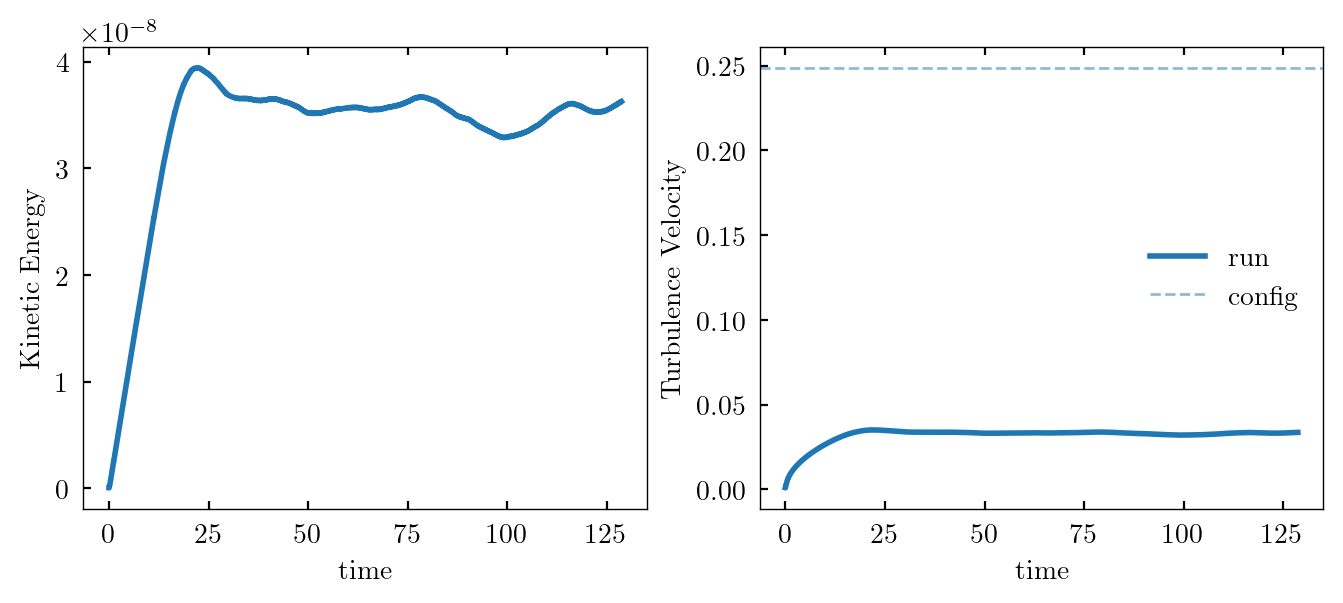

In [139]:

trial = '240613_0.1_10'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
fname = f'{datapath}/turb/Turb.hst'

with open(fname, 'r') as file: keys_raw = file.readlines()[1]
keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}
print(keys)

time = dataf['time']
e_k = dataf['1-KE'] + dataf['2-KE'] + dataf['3-KE']

# plot the time evolution
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(time, e_k)
axs[0].set_xlabel('time'); axs[0].set_ylabel('Kinetic Energy')

# get vturb from the run
v_turb_run = np.sqrt(2 * e_k / dataf['mass'])
axs[1].plot(time, v_turb_run, label='run')
axs[1].axhline(rp['v_turb'], alpha=0.5, lw=1, ls='--', label='config')
axs[1].set_xlabel('time'); axs[1].set_ylabel('Turbulence Velocity')
axs[1].legend()
plt.show()

### Mach number

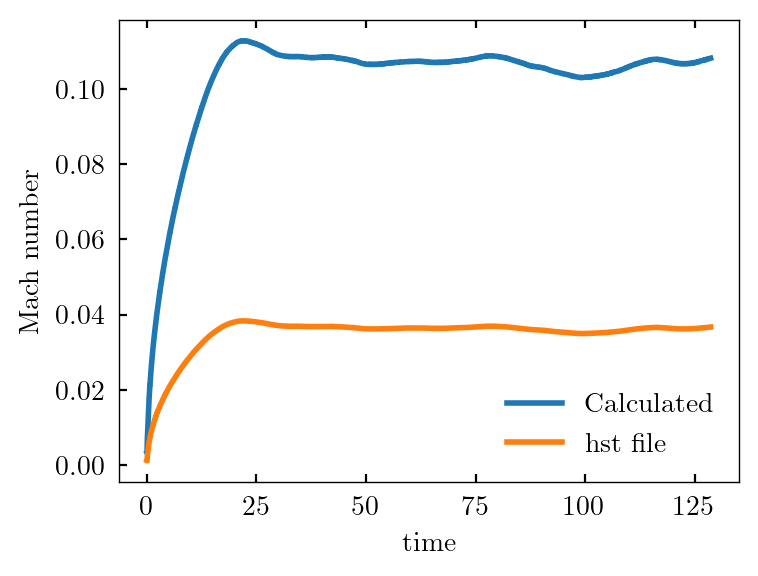

In [140]:
# mach number from calculated sound speed
mach_run = v_turb_run / calc_cs(rp['T_hot'])
# mach number from the turb.hst file
mach_run_hst = v_turb_run / dataf['c_s_sum'] * rp['grid_dim']**3

plt.subplots(figsize=(4, 3))
plt.plot(time, mach_run, label='Calculated')
plt.plot(time, mach_run_hst, label='hst file')
plt.xlabel('time'); plt.ylabel('Mach number')
plt.legend()
plt.show()
# extra energy goes into kinetic

## Pressure

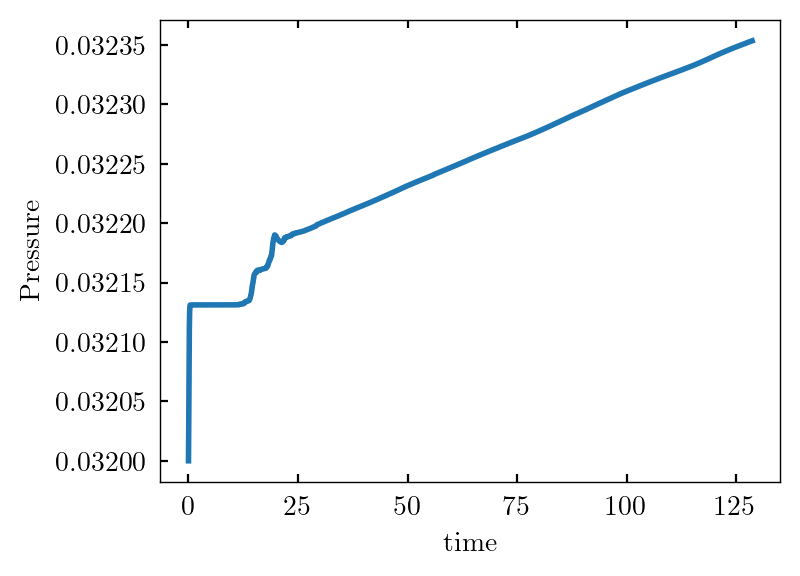

In [141]:
pressure_run = (dataf['T_sum'] / 64**3) * (dataf['rho_sum'] / 64**3) / (u.KELVIN * u.mu)
plt.subplots(figsize=(4, 3))
plt.plot(time, pressure_run)
plt.xlabel('time'); plt.ylabel('Pressure')
plt.show()
# in later stages of eddie driving, the temperature & pressure increases

## Density

In [142]:
plt.subplots(figsize=(4, 3))
for i, fnum in enumerate(np.arange(19, 109, 20).astype(int)):
    fname=f'{datapath}/turb/Turb.out2.000{fnum:.0f}.athdf'
    rho = get_datamd(fname=fname, verbose=False, key='rho').flatten()
    plt.hist(rho, alpha=0.1 * i, color='k')

# DELTA RHO / RHO　
plt.loglog()
plt.show()


KeyboardInterrupt



# Cloud

## Spatial distributions

In [ ]:
trial = '240628_0.6_1600000'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

In [ ]:
epoch_cloud = 1
epoch_end = 60

In [ ]:
"""
TEMPERATURE
"""

%matplotlib widget
from matplotlib.widgets import Button, Slider
fig, axs = plt.subplots(figsize=(12, 4), dpi=100)
fig.suptitle('Temperature')
axs.axis('off')
verbose = True
z_range = [0, rp['grid_dim']-1]
z_init = int(rp['grid_dim']/2)

# subplot 1
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud-1:05d}.athdf'
# plot run temperature BEFORE cloud
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature1 = calc_T(press, rho)
ax1 = plt.subplot(131)
ax1.set_xlabel('Before cloud')
img1 = plt.imshow(temperature1[z_init], interpolation='none', norm='log', vmin=400, vmax=100000000)
plt.colorbar()
plt.ioff()

# subplot 2
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud:05d}.athdf'
# plot run temperature AFTER cloud
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature2 = calc_T(press, rho)
ax2 = plt.subplot(132)
ax2.set_xlabel('After cloud')
img2 = plt.imshow(temperature2[z_init], interpolation='none', norm='log', vmin=400, vmax=100000000)
plt.colorbar()
plt.ioff()

# subplot 3
fname=f'{datapath}/cloud/Turb.out2.{epoch_end:05d}.athdf'
# plot run temperature AFTER cloud
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature3 = calc_T(press, rho)
ax3 = plt.subplot(133)
ax3.set_xlabel('End')
img3 = plt.imshow(temperature3[z_init], interpolation='none', norm='log', vmin=400, vmax=100000000)
plt.colorbar()
plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img1.set_data(temperature1[int(z)])
    img2.set_data(temperature2[int(z)])
    img3.set_data(temperature3[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)

plt.show()
%matplotlib inline
plotting_def()


In [ ]:
"""
DENSITY
"""

%matplotlib widget
from matplotlib.widgets import Button, Slider
fig, axs = plt.subplots(figsize=(12, 4), dpi=100)
fig.suptitle('Density')
axs.axis('off')
verbose = False
z_range = [0, rp['grid_dim']-1]
z_init = int(rp['grid_dim']/2)

# subplot 1
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud-1:05d}.athdf'
# plot run temperature BEFORE cloud
rho1 = get_datamd(fname=fname, verbose=verbose, key='rho')
ax1 = plt.subplot(131)
ax1.set_xlabel('Before cloud')
img1 = plt.imshow(rho1[z_init], interpolation='none', norm='log', vmin=3e-2, vmax=1e1, cmap='magma_r')
plt.colorbar()
plt.ioff()

# subplot 2
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud:05d}.athdf'
# plot run temperature AFTER cloud
rho2 = get_datamd(fname=fname, verbose=verbose, key='rho')
ax2 = plt.subplot(132)
ax2.set_xlabel('After cloud')
img2 = plt.imshow(rho2[z_init], interpolation='none', norm='log', vmin=3e-2, vmax=1e1, cmap='magma_r')
plt.colorbar()
plt.ioff()

# subplot 3
fname=f'{datapath}/cloud/Turb.out2.{epoch_end:05d}.athdf'
# plot run temperature AFTER cloud
rho3 = get_datamd(fname=fname, verbose=verbose, key='rho')
ax3 = plt.subplot(133)
ax3.set_xlabel('End')
img3 = plt.imshow(rho3[z_init], interpolation='none', norm='log', vmin=3e-2, vmax=1e1, cmap='magma_r')
plt.colorbar()
plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img1.set_data(rho1[int(z)])
    img2.set_data(rho2[int(z)])
    img3.set_data(rho3[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)

plt.show()
%matplotlib inline
plotting_def()


In [ ]:
"""
SCALAR
"""

%matplotlib widget
from matplotlib.widgets import Button, Slider
fig, axs = plt.subplots(figsize=(12, 4), dpi=100)
fig.suptitle('Scalar')
axs.axis('off')
verbose = False
z_range = [0, rp['grid_dim']-1]
z_init = int(rp['grid_dim']/2)

# subplot 1
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud-1:05d}.athdf'
# plot run temperature BEFORE cloud
scalar1 = get_datamd(fname=fname, verbose=verbose, key='r0')
ax1 = plt.subplot(131)
ax1.set_xlabel('Before cloud')
img1 = plt.imshow(scalar1[z_init], interpolation='none', norm='log', vmin=1e-4, vmax=1, cmap='magma_r')
plt.colorbar()
plt.ioff()

# subplot 2
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud:05d}.athdf'
# plot run temperature AFTER cloud
scalar2 = get_datamd(fname=fname, verbose=verbose, key='r0')
ax2 = plt.subplot(132)
ax2.set_xlabel('After cloud')
img2 = plt.imshow(scalar2[z_init], interpolation='none', norm='log', vmin=1e-4, vmax=1, cmap='magma_r')
plt.colorbar()
plt.ioff()

# subplot 3
fname=f'{datapath}/cloud/Turb.out2.{epoch_end:05d}.athdf'
# plot run temperature AFTER cloud
scalar3 = get_datamd(fname=fname, verbose=verbose, key='r0')
ax3 = plt.subplot(133)
ax3.set_xlabel('End')
img3 = plt.imshow(scalar3[z_init], interpolation='none', norm='log', vmin=1e-4, vmax=1, cmap='magma_r')
plt.colorbar()
plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img1.set_data(scalar1[int(z)])
    img2.set_data(scalar2[int(z)])
    img3.set_data(scalar3[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)

plt.show()
%matplotlib inline
plotting_def()


## Histograms

In [27]:
trial = '240708_0.6_1600000'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

In [28]:
epoch_cloud = 1
epoch_end = 60

In [ ]:
"""Temperature"""

fig, axs = plt.subplots(figsize=(12, 4), dpi=100)
axs.axis('off')

# before cloud
ax1 = plt.subplot(131)
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud-1:05d}.athdf'
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)
ax1.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
ax1.text(1e4, 1000, 'Before cloud')

# after cloud
ax2 = plt.subplot(132)
fname=f'{datapath}/cloud/Turb.out2.{epoch_cloud:05d}.athdf'
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)
ax2.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
ax2.text(1e4, 1000, 'After cloud')

# at the end
ax3 = plt.subplot(133)
fname=f'{datapath}/cloud/Turb.out2.{epoch_end:05d}.athdf'
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)
ax3.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
ax3.text(1e4, 1000, 'End')

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e1, 1e7)
    ax.set_xlabel('$T$ [K]')
    ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
    ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')
plt.show()

In [ ]:
"""Temperature"""

tot_frames = 9
fig, axs = plt.subplots(figsize=(tot_frames * 4, 4), dpi=100)
axs.axis('off')

# before cloud
for i in range(tot_frames):
    epoch_num = epoch_cloud + i * 6
    ax = plt.subplot(int(f'{1}{tot_frames}{i+1}'))
    fname=f'{datapath}/cloud/Turb.out2.{epoch_num:05d}.athdf'
    rho = get_datamd(fname=fname, verbose=False, key='rho')
    press = get_datamd(fname=fname, verbose=False, key='press')
    temperature = calc_T(press, rho)
    ax.hist(temperature.flatten(), alpha=0.5,
             bins=np.logspace(np.log10(400), np.log10(2e7), 100))
    ax.text(1e4, 1000, f'Snapshot {epoch_num}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e1, 1e7)
    ax.set_xlabel('$T$ [K]')
    # ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
    # ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')

plt.show()

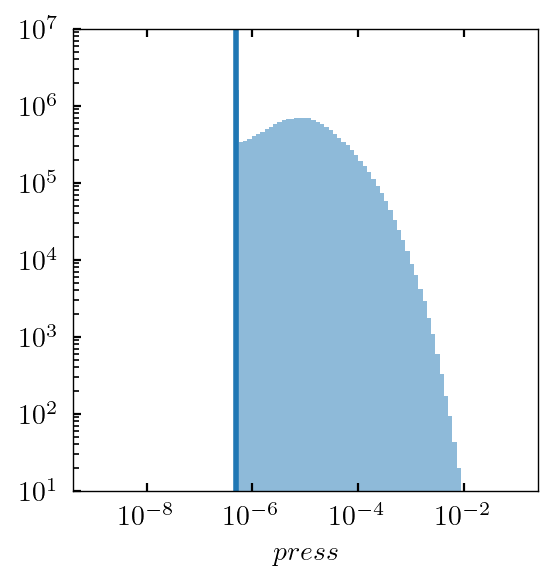

In [18]:
"""Pressure"""
import os
trial = '240702_0.6_1600'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
# epoch = 
# fname=f'{datapath}/cloud/Turb.out2.{epoch:05d}.athdf'

# get the LAST epoch
athdf_files = [file for file in os.listdir(f'{datapath}/cloud') if file.startswith("Turb.out2.") and file.endswith(".athdf")]
last_file = np.sort(athdf_files)[-1]
middle_file = np.sort(athdf_files)[len(athdf_files)//2]

fname = f'{datapath}/cloud/{middle_file}'
press = get_datamd(fname=fname, verbose=False, key='press')

fig, ax = plt.subplots(figsize=(3,3))
ax.hist(press.flatten(), alpha=0.5,
        bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 100))
# ax.text(1e4, 1000, f'Snapshot {epoch_num}')

# pfloor=0.0005
pfloor = 5e-7
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e1, 1e7)
ax.axvline(x=pfloor)
ax.set_xlabel('$press$')
# ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
# ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')

plt.show()

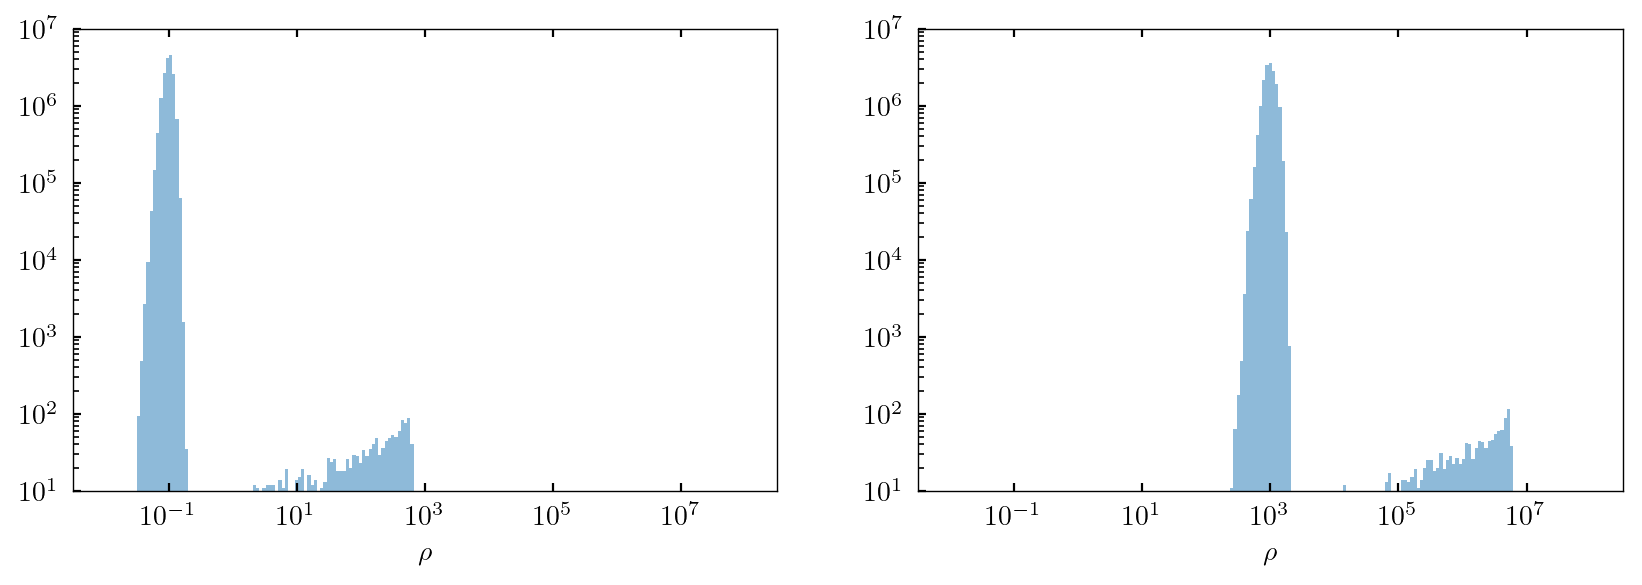

In [34]:
"""Density"""

fig, axs = plt.subplots(1, 2, figsize=(10,3))
for ax, trial in zip(axs, ['240708_0.6_1600000', '240709_0.6_1600000']):
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

    fname=f'{datapath}/cloud/Turb.out2.{1:05d}.athdf'
    rho = get_datamd(fname=fname, verbose=False, key='rho')

    ax.hist(rho.flatten(), alpha=0.5,
            bins=np.logspace(np.log10(1e-2), np.log10(1e8), 200))
    # ax.text(1e4, 1000, f'Snapshot {epoch_num}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e1, 1e7)
    ax.set_xlabel(r'$\rho$')
    # ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
    # ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')

plt.show()

In [ ]:
import pickle

trial = '240628_0.6_1600000'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)
# Import the cooling function from Hitesh's scripts
import sys
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/cooling_scripts'))
import cooling_fn as cf
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/helper_scripts'))
import v_turb as vt

# temperature range
T_arr = np.logspace(np.log10(rp['T_floor']),
                    np.log10(rp['T_ceil']), 100)  # in kelvin
rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr

"""
Cooling & Heating functions
"""
Gamma_n_arr = 1e-26 / rho_arr
Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

"""
Cooling & Heating rates
"""
heating_rate = 1e-26 * rho_arr
cooling_rate = Lambda_arr * rho_arr**2

"""
Timescale
"""
tcool_arr = np.vectorize(cf.tcool_calc)(
    rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
)

"""
Shattering length
"""
def calc_cs(T):
    m_to_cm = 100
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity
t_cool_func = lambda T : cf.tcool_calc(rp['rho_hot'] * rp['T_hot'] / T, T, Zsol=1.0, Lambda_fac=1.0, fit_type="max")
l_shatter = np.vectorize(t_cool_func)(T_arr) * calc_cs(T_arr)

"""
Minimum l_shatter
"""
# calculate geometric mean T_mix
# the two limits
T_cold = rp['T_cloud']  # set cold temperature to that of cloud
T_hot = rp['T_hot']

"""T_mix calculations"""
# the params in range
T_ind_low, T_ind_high = find_ind_l(T_arr, T_cold), find_ind_l(T_arr, T_hot)
T_range = T_arr[T_ind_low : T_ind_high]
tcool_range = tcool_arr[T_ind_low : T_ind_high]

T_tcoolmin = T_range[np.argmin(tcool_range)]  # the temperature corresponding to the lowest t_cool
T_mix = np.sqrt(T_tcoolmin * T_hot)  # use the temperature at which t_cool is lowest instead of this:  # T_mix = np.sqrt(T_cold * T_hot)  # use the cloud temperature

t_cool_min = np.min(tcool_range)
t_cool_mix = t_cool_func(T_mix)
t_cool_cold = t_cool_func(T_cold)

l_shatter_min = np.min(l_shatter[T_ind_low : T_ind_high])




# get retrieve the values from one snapshot

fname=f'{datapath}/cloud/Turb.out2.{50:05d}.athdf'
rho_all = get_datamd(fname=fname, verbose=False, key='rho').flatten()
press_all = get_datamd(fname=fname, verbose=False, key='press').flatten()
T_all = calc_T(press_all, rho_all)
t_cool_all = np.vectorize(cf.tcool_calc)(rho_all, T_all, Zsol=1.0, Lambda_fac=1.0, fit_type="max")


plt.figure(figsize=(4, 3))
plt.scatter(T_all, t_cool_all)
plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")
plt.axhline(y=rp['t_cc'], color="k", linestyle="-", alpha=0.2, label=r"$t_{\rm cc}$")
plt.axhline(y=rp['t_eddy'], color="k", linestyle="-", alpha=0.2, label=r"$t_{\rm eddy}$")
plt.ylabel(r"$t_{\rm cool} [u]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.axvline(x=rp['T_floor'], lw=1, color="k", linestyle="--")
plt.axvline(x=rp['T_cloud'], lw=1, color="slateblue", linestyle="--")
plt.axvline(x=T_tcoolmin, lw=1, color="slateblue", linestyle="-.", alpha=0.2)
plt.axvline(x=T_mix, lw=1, color="green", linestyle="-.", alpha=0.2)
plt.axvline(x=rp['T_hot'], lw=1, color="orangered", linestyle="--")
plt.show()

In [ ]:
np.sum(np.isclose(rho_all, 0))

In [ ]:
"""Temperature"""
trial = '240610_0.6_2032'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
tot_frames = 9
fig, axs = plt.subplots(figsize=(tot_frames * 4, 4), dpi=100)
axs.axis('off')

# before cloud
for i in range(tot_frames):
    epoch_num = epoch_cloud + i * 6 + 100
    ax = plt.subplot(int(f'{1}{tot_frames}{i+1}'))
    fname=f'{datapath}/cloud/Turb.out2.{epoch_num:05d}.athdf'
    rho = get_datamd(fname=fname, verbose=False, key='rho')
    press = get_datamd(fname=fname, verbose=False, key='press')
    temperature = calc_T(press, rho)
    ax.hist(temperature.flatten(), alpha=0.5,
             bins=np.logspace(np.log10(400), np.log10(2e7), 100))
    ax.text(1e4, 1000, f'Snapshot {epoch_num}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e1, 1e7)
    ax.set_xlabel('$T$ [K]')
    # ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
    # ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')

plt.show()

In [ ]:
"""Temperature"""

fig, axs = plt.subplots(figsize=(12, 4), dpi=100)
axs.axis('off')

# before cloud
ax1 = plt.subplot(131)
fname=f'{datapath}/turb/Turb.out2.{80:05d}.athdf'
print(fname)
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)
ax1.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
ax1.text(1e4, 1000, 'Before cloud')

# after cloud
ax2 = plt.subplot(132)
fname=f'{datapath}/cloud/Turb.out2.{1:05d}.athdf'
print(fname)
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)
ax2.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
ax2.text(1e4, 1000, 'After cloud')

# at the end
ax3 = plt.subplot(133)
fname=f'{datapath}/cloud/Turb.out2.{10:05d}.athdf'
print(fname)
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)
ax3.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
ax3.text(1e4, 1000, 'End')

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e1, 1e7)
    ax.set_xlabel('$T$ [K]')
    ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
    ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')
plt.show()

In [ ]:
trial = '240628_0.6_1600000'

rho = get_datamd(fname=f'/freya/ptmp/mpa/wuze/data/{trial}/cloud/Turb.out2.00000.athdf', key='rho', verbose=False)

plt.hist(rho.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(1e-2), np.log10(2e7), 100))

rho_gas = 0.1
rho_cloud = rho_gas * 5000
plt.axvline(rho_gas)
plt.axvline(rho_cloud)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
fname = f'{datapath}/turb/Turb.hst'

with open(fname, 'r') as file: keys_raw = file.readlines()[1]
keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}

# mach number from calculated sound speed
mach_run = v_turb_run / calc_cs(rp['T_hot'])
# mach number from the turb.hst file
mach_run_hst = v_turb_run / dataf['c_s_sum'] * rp['grid_dim']**3

plt.subplots(figsize=(4, 3))
plt.plot(time, mach_run, label='Calculated')
plt.plot(time, mach_run_hst, label='hst file')
plt.xlabel('time'); plt.ylabel('Mach number')
plt.legend()
plt.show()
# extra energy goes into kinetic

# Different epoches

In [ ]:
# construct a list of files
file_list = []
for fnum in np.arange(cloud_epoch, end_epoch+1, 1).astype(int):
    fname = f'{datapath}/cloud/Turb.out2.{fnum:05d}.athdf'
    file_list.append(fname)

# Initialize frames list
frames_T = []
frames_rhosq = []

# Loop over filenames to create frames
for fname in file_list:
    rho = get_datamd(fname=fname, verbose=False, key='rho')
    press = get_datamd(fname=fname, verbose=False, key='press')
    temperature = calc_T(press, rho)

    # flatten density sq
    rhosq2d = np.sum(np.square(rho), axis=0)
    frames_rhosq.append(rhosq2d)
    
    # flatten temperature
    temperature2d = np.sum(temperature, axis=0)
    frames_T.append(temperature2d)

## Projection animations

In [163]:
trial = '240612_0.3_40'  # rp.trial
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

In [164]:
# cloud_epoch = 101
# end_epoch = 180

cloud_epoch = 1
end_epoch = 80

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x152781d6d970>>
Traceback (most recent call last):
  File "/freya/ptmp/mpa/wuze/miniconda3/lib/python3.12/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/freya/ptmp/mpa/wuze/miniconda3/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1233, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/freya/ptmp/mpa/wuze/miniconda3/lib/python3.12/site-packages/matplotlib/animation.py", line 1427, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/freya/ptmp/mpa/wuze/miniconda3/lib/python3.12/site-packages/matplotlib/animation.py", line 1121, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/freya/ptmp/mpa/wuze/miniconda3/lib/python3.12/site-packages/matplotlib/animation.py", l

In [165]:
import matplotlib.animation as animation
from tqdm import tqdm

# construct a list of files
file_list = []
for fnum in np.arange(cloud_epoch, end_epoch+1, 1).astype(int):
    fname = f'{datapath}/cloud/Turb.out2.{fnum:05d}.athdf'
    file_list.append(fname)

# Initialize frames list
frames_T = []
frames_press = []
frames_rhosq = []

# Loop over filenames to create frames
for fname in tqdm(file_list):
    rho = get_datamd(fname=fname, verbose=False, key='rho')
    press = get_datamd(fname=fname, verbose=False, key='press')
    temperature = calc_T(press, rho)

    # flatten density sq
    rhosq2d = np.sum(np.square(rho), axis=0)
    frames_rhosq.append(rhosq2d)
    
    # slice temperature
    # temperature2d = np.sum(temperature, axis=0)
    temperature2d = temperature[len(temperature) // 2]
    frames_T.append(temperature2d)

    # slice pressure
    pressure2d = press[len(press) // 2]
    frames_press.append(pressure2d)

100%|████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:52<00:00,  1.41s/it]


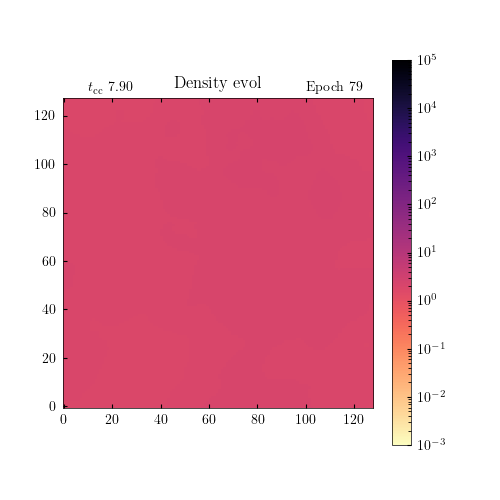

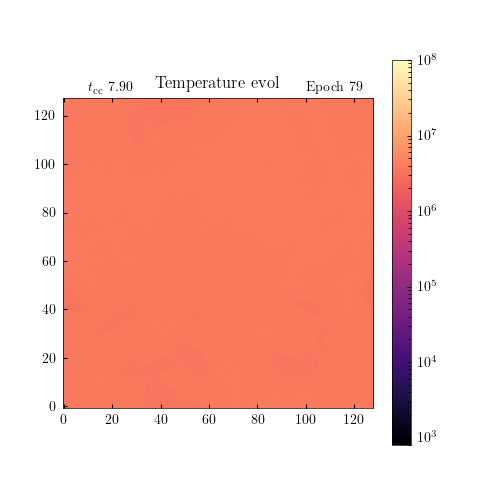

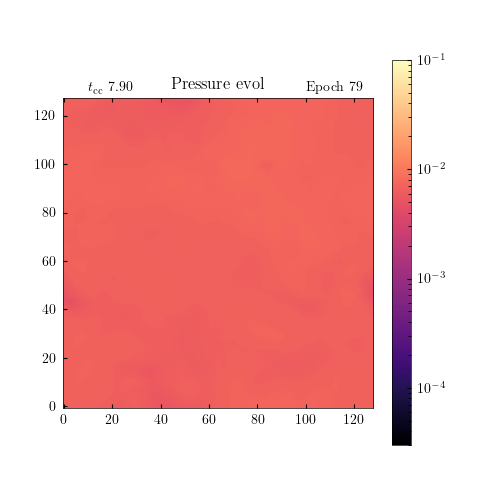

In [166]:
def animate_prop(frames_prop=frames_T, prop_name='temperature'):
    %matplotlib widget
    from matplotlib.colors import LogNorm
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    if prop_name == 'Density':
        img = plt.imshow(frames_prop[0], interpolation='none', norm=LogNorm(vmin=1e-3, vmax=1e5), cmap='magma_r')  # density
    elif prop_name == 'Temperature':
        img = plt.imshow(frames_prop[0], interpolation='none', norm=LogNorm(vmin=8e2, vmax=1e8), cmap='magma')  # temperature
    elif prop_name == 'Pressure':
        img = plt.imshow(frames_prop[0], interpolation='none', norm=LogNorm(vmin=3e-5, vmax=1e-1), cmap='magma')  # pressure
    else:
        print('Not a valid property name')
        return
    
    # time in epoch
    epoch_text = plt.text(100, 130, f'Epoch {cloud_epoch}')
    # time in t_cc
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)
    
    time_in_tcc = rp['dt_hdf5'] / rp['t_cc'] * cloud_epoch
    tcc_text = plt.text(10, 130, fr'$t_{{\rm cc}}$ {time_in_tcc:.2f}')
    
    plt.title(f'{prop_name} evol')
    plt.colorbar()
    plt.ioff()
    
    # Update the frame
    def update(iframe):
        img.set_data(frames_prop[iframe])
        epoch_text.set_text(f'Epoch {cloud_epoch+iframe}')
        time_in_tcc = rp['dt_hdf5'] / rp['t_cc'] * (cloud_epoch+iframe)
        tcc_text.set_text(fr'$t_{{\rm cc}}$ {time_in_tcc:.2f}')
        return [img, epoch_text, tcc_text]
    
    ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(end_epoch - cloud_epoch), interval=100, blit=True)
    ani.save(filename=f"figs/240702/{trial}_{prop_name}_flatten.gif".lower(), writer="pillow")
    plt.show()
    %matplotlib inline

animate_prop(frames_rhosq, prop_name='Density')
animate_prop(frames_T, prop_name='Temperature')
animate_prop(frames_press, prop_name='Pressure')

## Cloud survival

In [ ]:
# cutoff temperature for cold and hot gas
T_cold_cut = rp['T_cloud'] * 2
T_hot_cut = rp['T_hot']

T_cold_cut, T_hot_cut

In [ ]:
import numpy as np

"""construct a list of files"""
file_list = []
for fnum in np.arange(epoch_cloud+1, epoch_end+1, 1).astype(int):
    fname = f'{datapath}/cloud/Turb.out2.{fnum:05d}.athdf'
    file_list.append(fname)

"""array of hot / cold gas mass"""
mass_cg = []
mass_hg = []
time_athdf = []

# calculate grid volume
grid_size = 1 / 64 ** 3

In [ ]:
from tqdm import tqdm
for fname in tqdm(file_list):
    t = get_datamd(fname=fname, verbose=False, key='Time')
    rho = get_datamd(fname=fname, verbose=False, key='rho').flatten()
    press = get_datamd(fname=fname, verbose=False, key='press').flatten()
    temperature = calc_T(press, rho)

    # select cold and hot gas densities
    cgm = np.sum(rho[temperature <= T_cold_cut]) * grid_size
    hgm = np.sum(rho[temperature >= T_hot_cut]) * grid_size

    # append
    time_athdf.append(t)
    mass_cg.append(cgm); mass_hg.append(hgm)

# the time for athena
mass_cg = np.array(mass_cg)
mass_hg = np.array(mass_hg)

In [ ]:
mass_cg

In [ ]:
# plot athdf version
fig, ax1 = plt.subplots(figsize=(5,3))
cg_st_epoch = 40
ax1.plot(time_athdf / rp['dt_hdf5'], mass_cg / mass_cg[0], ls='--', label='hst')
# ax1.set_yscale('log')

# ax1.set_yscale('log')
ax1.set_ylabel('Cold mass [ini mass]')
ax1.set_xlabel('Time [epochs]')

# alternative t_cc axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
t_cc_lin = np.linspace(0, 100, 5)
ax2.set_xticks(rp['t_cc'] / rp['dt_hdf5'] * t_cc_lin)
ax2.set_xticklabels(t_cc_lin)
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

plt.legend()
plt.show()

In [ ]:
log_mass_frac = np.log10(mass_cg[-1] / mass_cg[0])
log_mass_frac

# All in one temperature

In [22]:
trial = '240702_0.6_1600'

In [23]:
"""
Plots the temperature distribution on top of the cooling curve
Varies time
----------
time_athdf
temperature_athdf
"""

datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

import pickle
"""read parameters"""
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

print('Loaded parameters')

"""read pickle"""
with open(f'{datapath}/cloud/time_temperature', 'rb') as handle:
    time_athdf, temperature_athdf, _ = pickle.load(handle)

print('Loaded temperature history')

# Import the cooling function from Hitesh's scripts
import sys
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/cooling_scripts'))
import cooling_fn as cf
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/helper_scripts'))
import v_turb as vt

# temperature range
T_arr = np.logspace(np.log10(rp['T_floor']),
                    np.log10(rp['T_ceil']), 100)  # in kelvin
rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr

"""
Cooling & Heating functions
"""
Gamma_n_arr = 1e-26 / rho_arr
Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

"""
Cooling & Heating rates
"""
heating_rate = 1e-26 * rho_arr
cooling_rate = Lambda_arr * rho_arr**2

"""
Timescale
"""
tcool_arr = np.vectorize(cf.tcool_calc)(
    rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
)

def plot_tvlines(ax):
    ax.axvline(x=rp['T_floor'], color="k", linestyle="--")
    ax.axvline(x=rp['T_cloud'], color="slateblue", linestyle="--")
    ax.axvline(x=rp['T_mix'], color="green", linestyle="--", alpha=0.2)
    ax.axvline(x=rp['T_hot'], color="orangered", linestyle="--")
    # ax.axvline(x=T_cut color="k", linestyle="")

def plot_format(ax):
    ax.set_xlim(400, 2e7)
    ax.set_ylim(1e0, 1e6)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_xlabel(r"$T$(K)", fontsize=14)
    ax.set_yscale("log")
    ax.set_xscale("log")

Loaded parameters
Loaded temperature history


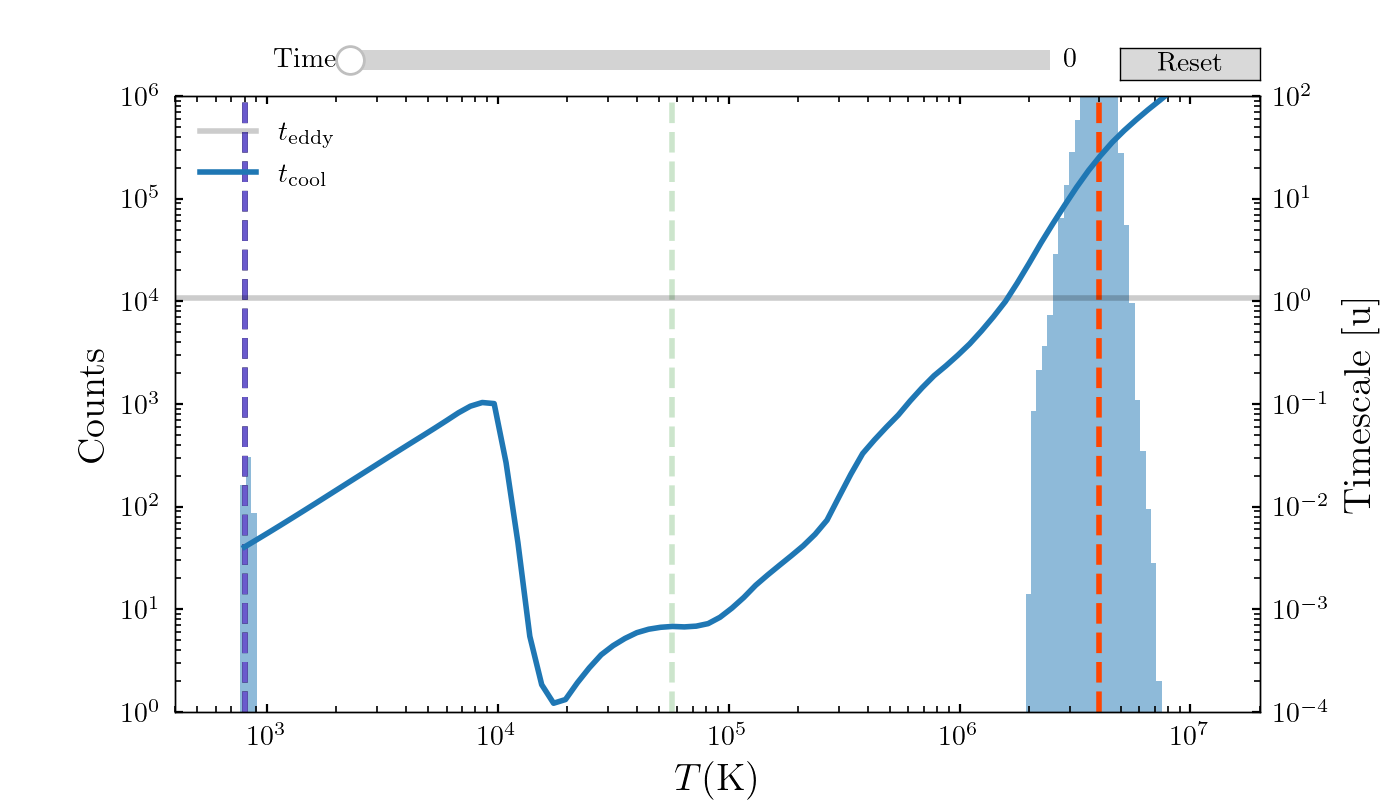

In [24]:
%matplotlib widget
from matplotlib.widgets import Button, Slider

fig, ax = plt.subplots(figsize=(7, 4))
nbins = 200

# histogram
_, _, hist = ax.hist(temperature_athdf[0].flatten(), alpha=0.5,
                bins=np.logspace(np.log10(400), np.log10(2e7), nbins))
plot_format(ax)
plot_tvlines(ax)

# make the timescale plots
ax2 = ax.twinx()
ax2.axhline(y=rp['t_eddy'], color="k", linestyle="-", alpha=0.2, label=r"$t_{\rm eddy}$")
ax2.plot(T_arr, tcool_arr, label=r"$t_{\rm cool}$")
ax2.set_ylim(1e-4, 1e2)
ax2.set_ylabel('Timescale [u]', fontsize=14)
ax2.set_yscale("log")

ax2.legend()

"""
Interactive plot
"""
# Make a horizontal slider to control the T_cold
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
time_slider = Slider(
    ax=ax_slider,
    label='Time',
    valmin=0,
    valmax=len(time_athdf)-1,
    valinit=0,
    valfmt='%1.0f',
    valstep=1,
)

# The function to be called anytime a slider's value changes
def update(val):
    index = int(time_slider.val)
    ax.cla()
    n, bins, patches = ax.hist(temperature_athdf[index].flatten(), alpha=0.5,
                                bins=np.logspace(np.log10(400), np.log10(2e7), nbins))
    plot_format(ax)
    plot_tvlines(ax)
    fig.canvas.draw_idle()

time_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    time_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

# Epochs plot (panels)

In [13]:
# the row and columns to plot
trials = ['240715_0.8_16', '240711_0.4_1600', '240715_0.8_160000', '240711_0.8_160000000']
tccs = [0, 0.5, 1, 1.5]

from codes.plotting.paper import *
num_runs, num_epochs, temp_data, dens_proj, rcls = \
density_evol_load(trials=trials, tccs=tccs)

/freya/ptmp/mpa/wuze/data/240711_0.8_160000000/cloud/Turb.out2.00000.athdf
/freya/ptmp/mpa/wuze/data/240711_0.8_160000000/cloud/Turb.out2.00005.athdf
/freya/ptmp/mpa/wuze/data/240711_0.8_160000000/cloud/Turb.out2.00010.athdf
/freya/ptmp/mpa/wuze/data/240711_0.8_160000000/cloud/Turb.out2.00015.athdf
/freya/ptmp/mpa/wuze/data/240715_0.8_160000/cloud/Turb.out2.00000.athdf
/freya/ptmp/mpa/wuze/data/240715_0.8_160000/cloud/Turb.out2.00004.athdf
/freya/ptmp/mpa/wuze/data/240715_0.8_160000/cloud/Turb.out2.00009.athdf
/freya/ptmp/mpa/wuze/data/240715_0.8_160000/cloud/Turb.out2.00015.athdf
/freya/ptmp/mpa/wuze/data/240711_0.4_1600/cloud/Turb.out2.00000.athdf
/freya/ptmp/mpa/wuze/data/240711_0.4_1600/cloud/Turb.out2.00004.athdf
/freya/ptmp/mpa/wuze/data/240711_0.4_1600/cloud/Turb.out2.00009.athdf
/freya/ptmp/mpa/wuze/data/240711_0.4_1600/cloud/Turb.out2.00014.athdf
/freya/ptmp/mpa/wuze/data/240715_0.8_16/cloud/Turb.out2.00000.athdf
/freya/ptmp/mpa/wuze/data/240715_0.8_16/cloud/Turb.out2.00005.at

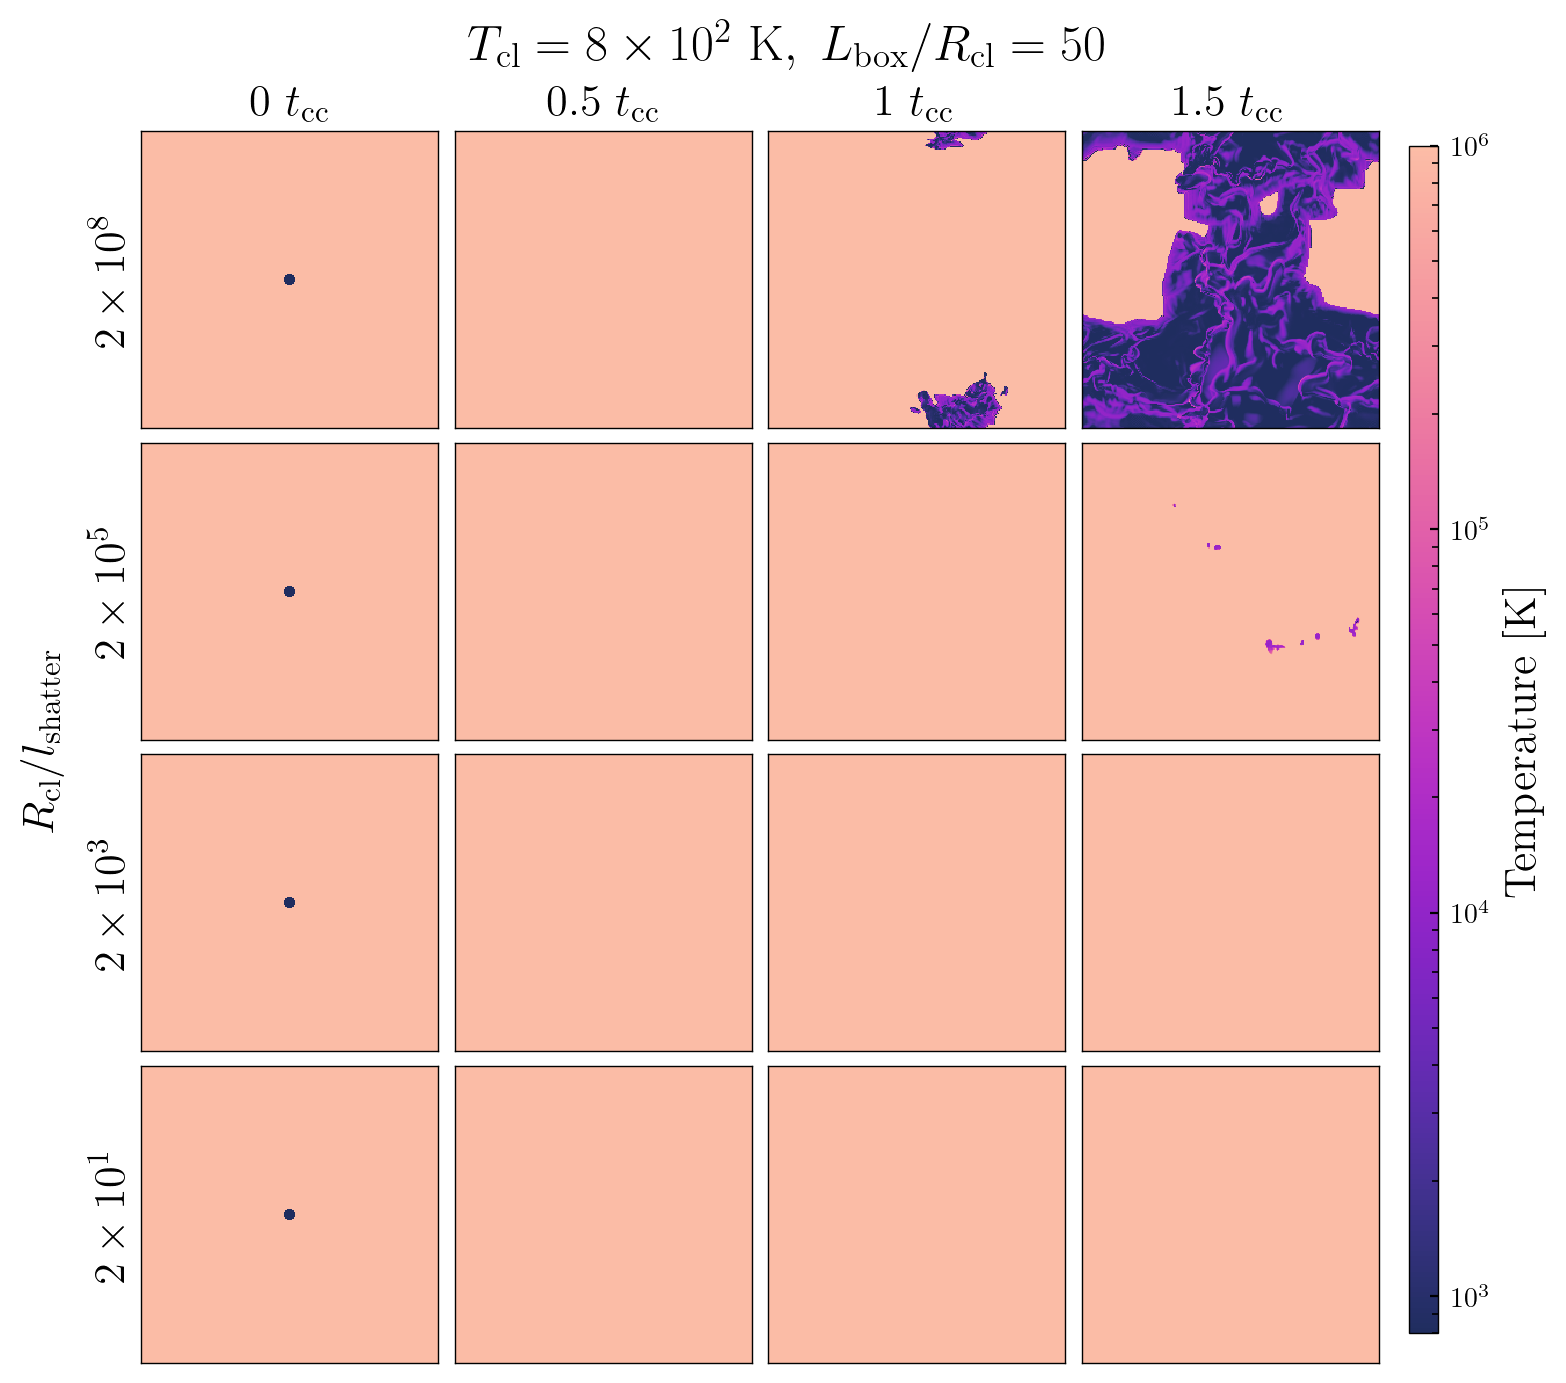

In [51]:
data = [num_runs, num_epochs, temp_data, dens_proj, rcls]

from codes.plotting.paper import *
density_evol_load(data, tccs, plot_temp=True, lfs=16, tfs=18)

# Compare mass evol history

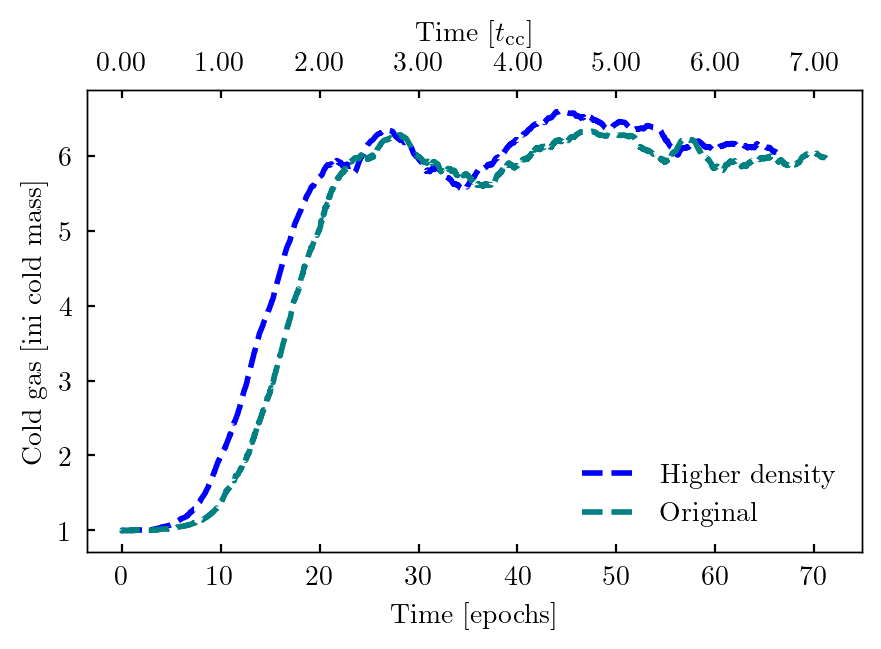

In [26]:
trials_list = [
    '240709_0.6_1600000', '240708_0.6_1600000'  # in this case, two trials with density & cloud scaled differently
]
colors_list = ['blue', 'teal']
labels_list = ['Higher density', 'Original']

fig, ax1 = plt.subplots(figsize=(5,3))
cg_st_epoch = 0
verbose = False; plot_warm = False

for trial, color, label in zip(trials_list, colors_list, labels_list):
    """
    Grab hst files
    """
    
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
    # grab the rp file
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)
    
    # grab the hst file data
    try:  # if the turb has headers
        fname = f'{datapath}/turb/Turb.hst'
        with open(fname, 'r') as file: keys_raw = file.readlines()[1]
        keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
    except:
        fname = f'{datapath}/cloud/Turb.hst'
        with open(fname, 'r') as file: keys_raw = file.readlines()[1]
        keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
    
    # load the actual hst
    fname = f'{datapath}/cloud/Turb.hst'
    data = np.loadtxt(fname).T
    dataf = {keys[i]: data[i] for i in range(len(keys))}
    if verbose: print(dataf['cold_gas']); print(dataf['warm_gas'])
    log_cold_frac = np.log10(dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch])  # cold gas fraction
    
    """
    Make plot
    """
    
    # plot hst version
    cg_st_epoch = 0
    ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', color=color, label=label)#f'Cold {trial}')
    if plot_warm:
        log_warm_frac = np.log10(dataf['warm_gas'] / dataf['cold_gas'][cg_st_epoch])  # warm gas fraction
        ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['warm_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', color='orange', label=f'Warm {trial}')
    # ax1.set_yscale('log')
    
    ax1.set_ylabel('Gas mass [ini cold mass]' if plot_warm else 'Cold gas mass [ini cold mass]')
    ax1.set_xlabel('Time [epochs]')
    ax1.legend()
    
# alternative t_cc axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
t_cc_ticks = np.arange(0, ax1.get_xlim()[1], 10)
t_cc_labels = (t_cc_ticks * rp['dt_hdf5']) / rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels(f'{x:.2f}' for x in t_cc_labels)
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

plt.show()

In [37]:
4/3 * np.pi * (1/50)**3 / 1 * 5000

0.16755160819145565

# Pressure evolution

In [10]:
def get_datamds(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
                keys=['rho'], verbose=False):
    """
    Get and plot data for 2d/3d runs
    """
    data = athdf(filename=fname,)
    if verbose: print(list(data.keys()))
    vals = []
    for key in keys:
        try:
            len(data[key])
            vals.append(data[key][0] if len(data[key]) == 1 else data[key])
        except:
            vals.append(data[key])
    return vals
    
p, rho, r = get_datamds(fname='/freya/ptmp/mpa/wuze/data/240620_0.8_320/cloud/Turb.out2.00000.athdf', keys=['press', 'rho', 'r0'], verbose=True)

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'r0']


In [18]:
trial = '240708_0.6_1600000'
cold_cloud_ratio = 2  # T_cold / T_cloud

from tqdm import tqdm
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

"""read parameters"""
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

"""construct a list of files"""
file_list = np.sort([f'{datapath}/cloud/{f}' for f in os.listdir(f'{datapath}/cloud') if f.startswith('Turb.out2') and f.endswith('.athdf')])
end_epoch = int(file_list[-1].split('.')[-2])  # get the last snapshot

# calculate cold gas temperature
T_cold = rp['T_cloud'] * cold_cloud_ratio    

# arrays to append to
time_athdf = []  # time array for the athdfs
temperature_athdf = []  # an array of temperature vals
pressure_athdf = []  # an array of pressure vals

# calculate grid volume
grid_size = 1 / rp['grid_dim'] ** 3

for fname in tqdm(file_list):
    t, press, rho = get_datamds(fname=fname, keys=['Time', 'press', 'rho'], verbose=False)
    temperature = calc_T(press, rho)  # calculate temperature from the two
    # mass = rho * grid_size
    
    # append values
    time_athdf.append(t)
    pressure_athdf.append(np.array(press).flatten())
    temperature_athdf.append(np.array(temperature).flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████| 73/73 [17:42<00:00, 14.56s/it]


## Pressure vs time hist

In [ ]:
# bins for pressure
nbins_pressure = 200
plim = [1e-10, 1e-1]
bins_pressure = np.linspace(plim[0], plim[1], nbins_pressure)

# time bins
bins_time = time_athdf/rp['dt_hdf5']

"""
Time and pressure, as flattened scatter points
"""
# construct all points
all_time = []
for time, press in tqdm(zip(bins_time, pressure_athdf)):
    all_time.append([time] * len(press))

# x y value
xyval = [np.array(all_time).flatten(), np.array(pressure_athdf).flatten(), np.array(temperature_athdf).flatten()]

73it [00:06, 10.99it/s]


In [ ]:
"""SAVE the xyval, since it takes so long to generate"""

import pickle

with open(f'{datapath}/cloud/time_pressure_temperature.pkl', 'wb') as handle:
    # append the time, temperature, and mass evolutions
    pickle.dump(xyval, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
"""LOAD the xyval, since it takes so long to generate"""

import pickle
from tqdm import tqdm

trial = '240708_0.6_1600000'
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

with open(f'{datapath}/cloud/time_pressure_temperature.pkl', 'rb') as handle:
    xyval = pickle.load(handle)

# bins for pressure
nbins_pressure = 200
plim = np.array([1e-10, 1e-1])
bins_pressure = np.power(10., np.linspace(np.log10(plim[0]), np.log10(plim[1]), nbins_pressure))

# time bins
time_athdf = np.unique(xyval[0])  # retrieve the times
bins_time = time_athdf/rp['dt_hdf5']

In [ ]:
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LogNorm

"""Make the image"""

pressure_athdf = np.reshape(xyval[1], [73, 16777216])
temperature_athdf = np.reshape(xyval[2], [73, 16777216])

imgdata = []
for time, press_arr in tqdm(zip(time_athdf, )):  # for each time save and its pressure array
    hist, _ = np.histogram(press_arr, bins=bins_pressure)
    imgdata.append(hist)

imgdata = np.array(imgdata).T
print('Successfully compiled data')

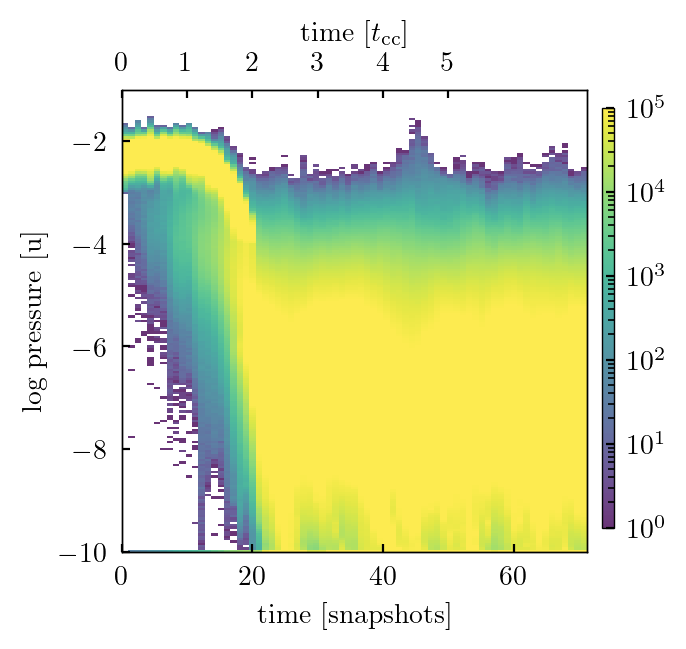

In [13]:
fig, ax1 = plt.subplots(figsize=(3, 3))

# show the image
img = \
ax1.imshow(imgdata,
           cmap='viridis', alpha=0.8,
           norm=LogNorm(vmin=1, vmax=1e5),
           aspect="auto",
           extent=[time_athdf.min(),time_athdf.max(),
                   np.log10(plim[0]), np.log10(plim[1])])

# colorbars
cbar_ax1 = fig.add_axes([0.925, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = plt.colorbar(img, cax=cbar_ax1)

# axis settings
ax1.set_ylim(np.log10(plim[0]), np.log10(plim[1]))
# ax1.set_yticks(ticks=np.linspace(0, 1, nbins_pressure), labels=bins_pressure)
ax1.set_ylabel('log pressure [u]')
ax1.set_xlabel('time [snapshots]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Set major ticks
t_cc_labels = np.linspace(0, ax2.get_xlim()[1] * rp['dt_hdf5'] / rp['t_cc'] // 5 * 5, 6)
t_cc_ticks = t_cc_labels / rp['dt_hdf5'] * rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels([f'{x:.0f}' for x in t_cc_labels])
ax2.set_xlabel(r"time [$t_{\rm cc}$]")

# Add minor ticks without labels between 0 and 5
minor_locator = FixedLocator(np.arange(0, 5, 1) / rp['dt_hdf5'] * rp['t_cc'])  # Adjust the interval as needed
ax2.xaxis.set_minor_locator(minor_locator)

# ax1.legend()
plt.show()

pfloor = 1e-10
0.02114325761795044


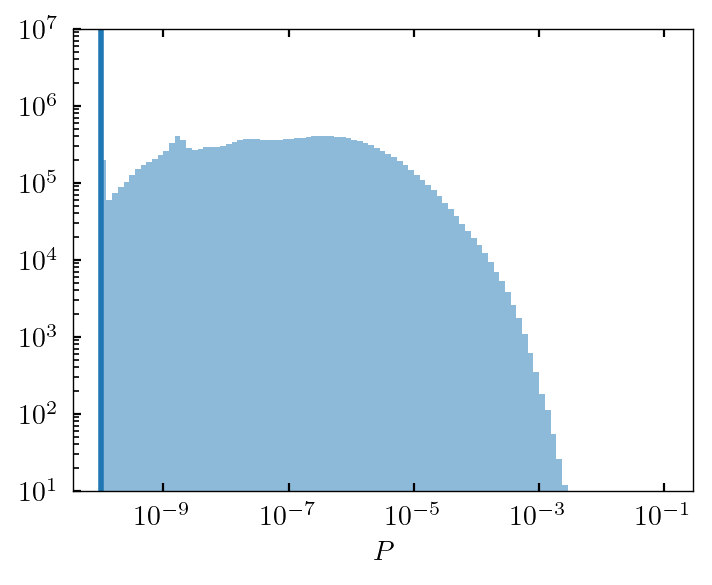

In [12]:
"""Pressure"""
import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena_pp/vis/python'))
import pickle
from athena_read import athdf
import h5py

trial='240708_0.6_1600000'
pfloor_def=0.0005

datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
# load properties
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)
try:
    pfloor = rp['pfloor']
except:
    pfloor = pfloor_def  # copy the pressure floor from input
print(f'pfloor = {pfloor}')

# get the LAST epoch
athdf_files = [file for file in os.listdir(f'{datapath}/cloud') if file.startswith("Turb.out2.") and file.endswith(".athdf")]
last_file = np.sort(athdf_files)[-1]
# middle_file = np.sort(athdf_files)[len(athdf_files)//2]

fname = f'{datapath}/cloud/{last_file}'
press = get_datamd(fname=fname, verbose=False, key='press')
press_flat = press.flatten()

# make the plot
fig, ax = plt.subplots(figsize=(4,3))
if np.any(press_flat < pfloor):
    print('!!!ERROR!!!')
    ax.hist(press_flat, alpha=0.5,
            bins=np.logspace(np.log10(np.min(press_flat)), np.log10(np.max(press_flat)), 100))
else:
    ax.hist(press_flat, alpha=0.5,
            bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 100) if pfloor < 1e-8 else np.logspace(np.log10(1e-8), np.log10(1e-0), 100) if pfloor < 0.0005 else np.logspace(np.log10(1e-4), np.log10(1e0), 100))
# ax.text(1e4, 1000, f'Snapshot {epoch_num}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e1, 1e7)
ax.axvline(x=pfloor)
ax.set_xlabel(r'$P$')
# ax.axvline(rp['T_hot'], color='red', lw=1, ls='--')
# ax.axvline(rp['T_cloud'], color='blue', lw=1, ls='--')

"""print the number of cells that are below limit"""
print(np.sum(press_flat < 2 * pfloor) / len(press_flat))

plt.show()

## Pressure vs temperature

In [31]:
"""
Make a scatter plot of temperature vs pressure
"""
trial = '240708_0.6_1600'
cold_cloud_ratio = 2  # T_cold / T_cloud

from tqdm import tqdm
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

"""read parameters"""
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

"""construct a list of files"""
file_list = np.sort([f'{datapath}/cloud/{f}' for f in os.listdir(f'{datapath}/cloud') if f.startswith('Turb.out2') and f.endswith('.athdf')])

t, press, rho = get_datamds(fname=file_list[-1], keys=['Time', 'press', 'rho'], verbose=False)
temperature = calc_T(press, rho)  # calculate temperature from the two

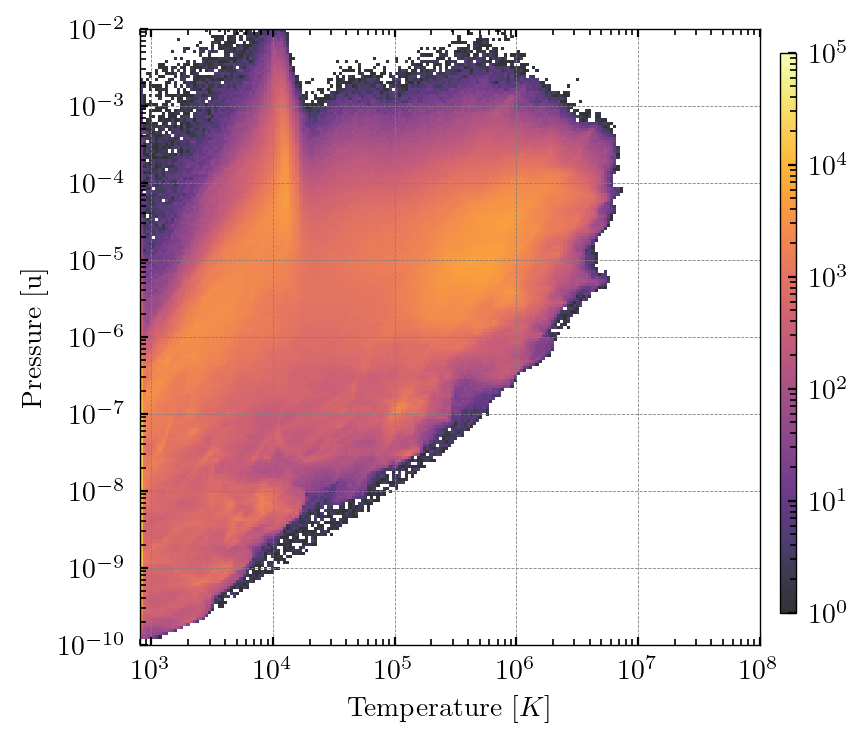

In [32]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(4, 4))
nbins = 200

img = \
ax.hist2d(temperature.flatten(), press.flatten(),
          bins=np.power(10., [np.linspace(np.log10(800), 8, nbins), np.linspace(-10, -2, nbins)]),
          cmap='inferno', alpha=0.8,
          norm=LogNorm(vmin=1, vmax=1e5),)[-1]

cbar_ax1 = fig.add_axes([0.925, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = plt.colorbar(img, cax=cbar_ax1)

ax.set_xlabel(r'Temperature [$K$]')
ax.set_ylabel(r'Pressure [u]')

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.show()

# Scalar evolution

In [30]:
def get_datamds(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
                keys=['rho'], verbose=False):
    """
    Get and plot data for 2d/3d runs
    """
    data = athdf(filename=fname,)
    if verbose: print(list(data.keys()))
    vals = []
    for key in keys:
        try:
            len(data[key])
            vals.append(data[key][0] if len(data[key]) == 1 else data[key])
        except:
            vals.append(data[key])
    return vals
    
p, rho, r = get_datamds(fname='/freya/ptmp/mpa/wuze/data/240620_0.8_320/cloud/Turb.out2.00000.athdf', keys=['press', 'rho', 'r0'], verbose=True)

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'r0']


In [52]:
trial = '240711_0.8_1600000'
cold_cloud_ratio = 2  # T_cold / T_cloud

from tqdm import tqdm
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

"""read parameters"""
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

"""construct a list of files"""
file_list = np.sort([f'{datapath}/cloud/{f}' for f in os.listdir(f'{datapath}/cloud') if f.startswith('Turb.out2') and f.endswith('.athdf')])
end_epoch = int(file_list[-1].split('.')[-2])

# calculate cold gas temperature
T_cold = rp['T_cloud'] * cold_cloud_ratio    

# arrays to append to
time_athdf = []  # time array for the athdfs
scalar_all = []  # an array containing ALL scalars
scalar_cold = []  # scalar percentage for the cold gas
scalar_warm = []  # scalar percentage for the warm gas
scalar_hot = []  # scalar percentage for the hot gas

# calculate grid volume
grid_size = 1 / rp['grid_dim'] ** 3

for fname in tqdm(file_list):
    t, press, rho, r = get_datamds(fname=fname, keys=['Time', 'press', 'rho', 'r0'], verbose=False)
    scalar = np.array(r) * np.array(rho)  # scalar is scaled by density
    temperature = calc_T(press, rho)  # calculate temperature from the two
    # mass = rho * grid_size
    
    # cells with cold, warm, and hot gas
    flag_cold = (temperature <= T_cold)
    flag_warm = np.logical_and(temperature > T_cold, temperature <= rp['T_warm'])
    flag_hot = (temperature > rp['T_cut'])

    # append values
    time_athdf.append(t)
    scalar_all.append(np.array(scalar).flatten())
    scalar_cold.append(np.array(scalar[flag_cold]).flatten())
    scalar_warm.append(np.array(scalar[flag_warm]).flatten())
    scalar_hot.append(np.array(scalar[flag_hot]).flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:29<00:00,  8.98s/it]


In [53]:
scalar_cold_sum = [np.sum(a) for a in scalar_cold]
scalar_warm_sum = [np.sum(a) for a in scalar_warm]
scalar_hot_sum = [np.sum(a) for a in scalar_hot]

## All scalar evol

Evolution of scalar distributions over snapshots

Takes every cell into account

- A bit unecessary, as we know everything will mix eventually

In [11]:
# scalar bins
nbins_scalar = 200
bins_scalar = np.linspace(0, 1, nbins_scalar)

# time bins
bins_time = time_athdf/rp['dt_hdf5']

# construct all points
all_time = []
for time, scal in zip(bins_time, scalar_all):
    all_time.append([time] * len(scal))

all_time, scalar_all

([[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,


In [12]:
xyval = [np.array(all_time).flatten(), np.array(scalar_all).flatten()]

In [13]:
# x_unraveled = np.nan_to_num([j for sub in all_time for j in sub])
# y_unraveled = np.nan_to_num([j for sub in scalar_all for j in sub])

# xyval = [x_unraveled, y_unraveled]

In [14]:
xyval[0]

array([ 0.        ,  0.        ,  0.        , ..., 71.21320344,
       71.21320344, 71.21320344])

In [15]:
xyval[1]

array([3.79484927e-19, 3.79556369e-19, 3.74974697e-19, ...,
       2.43151491e-05, 2.45191120e-05, 2.47303257e-05])

In [ ]:
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LogNorm

fig, ax1 = plt.subplots(figsize=(3, 3))

img = \
ax1.hist2d(x=xyval[0],
           y=xyval[1],
           bins=[bins_time, bins_scalar],
           cmap='viridis', alpha=0.8,
           norm=LogNorm(vmin=1, vmax=1e5))[3]

# colorbars
cbar_ax1 = fig.add_axes([0.925, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = plt.colorbar(img, cax=cbar_ax1)

# axis settings
ax1.set_ylim(0, 1)
ax1.set_ylabel('Scalar')
ax1.set_xlabel('Time [epochs]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Set major ticks
t_cc_labels = np.linspace(0, ax2.get_xlim()[1] * rp['dt_hdf5'] / rp['t_cc'] // 10 * 10, 5)
t_cc_ticks = t_cc_labels / rp['dt_hdf5'] * rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels([f'{x:.0f}' for x in t_cc_labels])
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

# Add minor ticks without labels between 0 and 5
minor_locator = FixedLocator(np.arange(0, 5, 1) / rp['dt_hdf5'] * rp['t_cc'])  # Adjust the interval as needed
ax2.xaxis.set_minor_locator(minor_locator)

ax1.legend()
plt.show()

## Temperature bin scaler evol

This simply shows the total scalar sum over time for each phase

- useful to track whether each phase is a result of cooling or mixing (which inevitably involves the cold gas)

In [32]:
box_cloud_ratio = 50 #20

ini_scalar_sum = (4/3 * np.pi * (1/box_cloud_ratio) **3) / grid_size
ini_scalar_sum

562.2099043550842

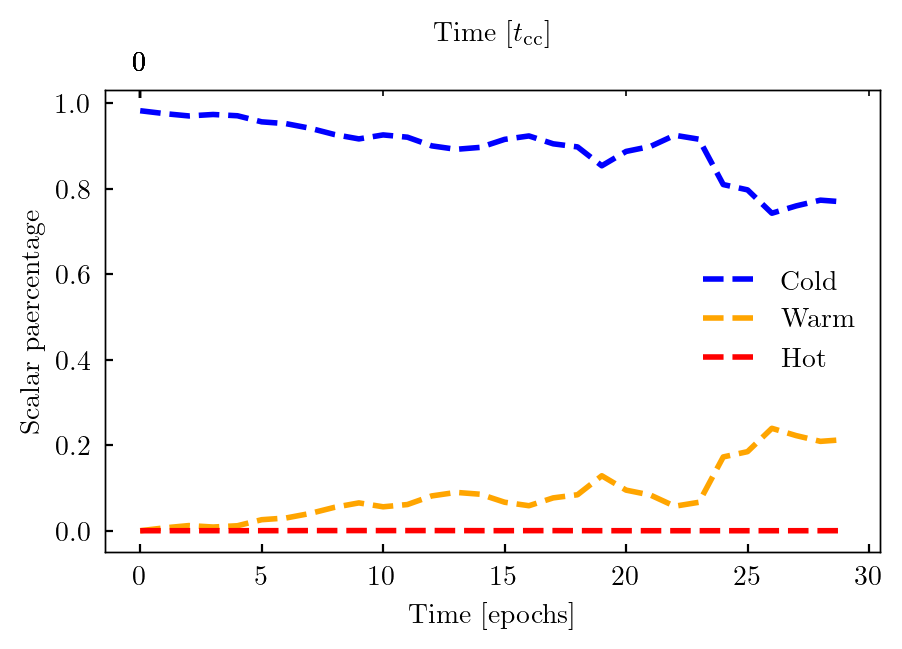

In [54]:
from matplotlib.ticker import FixedLocator

fig, ax1 = plt.subplots(figsize=(5,3))

# plot scalar evolution
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_cold_sum)/ini_scalar_sum, ls='--', color='blue', label='Cold')
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_warm_sum)/ini_scalar_sum, ls='--', color='orange', label='Warm')
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_hot_sum)/ini_scalar_sum, ls='--', color='red', label='Hot')

ax1.set_ylabel('Scalar paercentage')
ax1.set_xlabel('Time [epochs]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Set major ticks
t_cc_labels = np.linspace(0, ax2.get_xlim()[1] * rp['dt_hdf5'] / rp['t_cc'] // 10 * 10, 5)
t_cc_ticks = t_cc_labels / rp['dt_hdf5'] * rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels([f'{x:.0f}' for x in t_cc_labels])
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

# Add minor ticks without labels between 0 and 5
minor_locator = FixedLocator(np.arange(0, 5, 1) / rp['dt_hdf5'] * rp['t_cc'])  # Adjust the interval as needed
ax2.xaxis.set_minor_locator(minor_locator)

ax1.legend()
plt.show()

In [34]:
np.array(scalar_warm)/ini_scalar_sum

array([0.        , 0.00670122, 0.01204413, 0.00866872, 0.01162622,
       0.02576867, 0.02976684, 0.04042857, 0.05475603, 0.06506059,
       0.05592552, 0.06123028, 0.08137184, 0.08961312, 0.08532263,
       0.06661628, 0.05845813, 0.07677049, 0.084123  , 0.12849826,
       0.09488673, 0.08343516, 0.05727327, 0.06651808, 0.17250443,
       0.18486027, 0.23941089, 0.22237883, 0.20891014, 0.21310456])

## Temperature bin scaler evol (avg)

This shows the average of all scalar values in each phase

- useful to track whether each phase is a result of cooling or mixing (which inevitably involves the cold gas)

In [55]:
scalar_cold_mean = [np.mean(a) for a in scalar_cold]
scalar_warm_mean = [np.mean(a) for a in scalar_warm]
scalar_hot_mean = [np.mean(a) for a in scalar_hot]

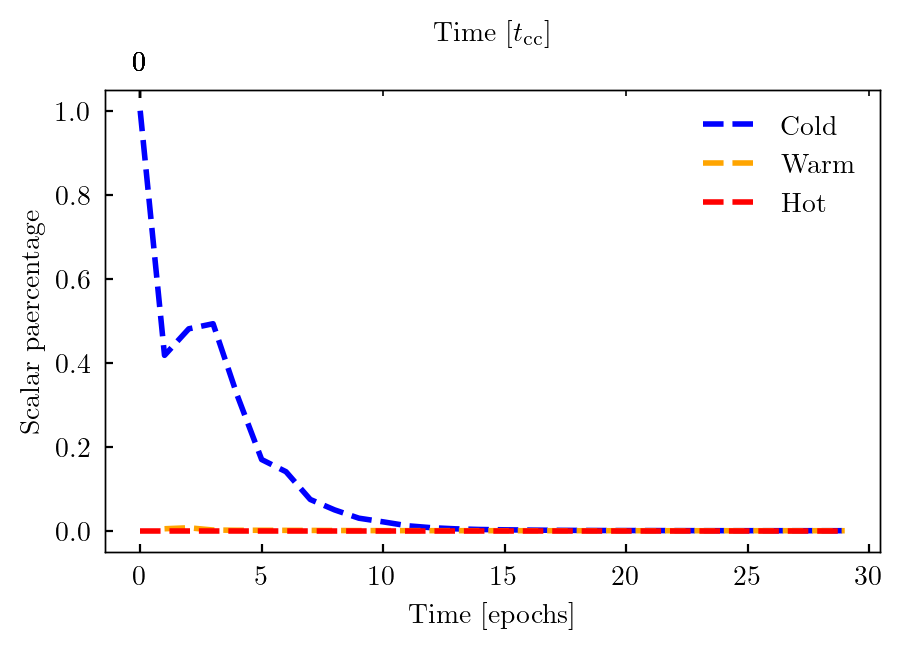

In [57]:
from matplotlib.ticker import FixedLocator

fig, ax1 = plt.subplots(figsize=(5,3))

# plot scalar evolution
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_cold_mean), ls='--', color='blue', label='Cold')
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_warm_mean), ls='--', color='orange', label='Warm')
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_hot_mean), ls='--', color='red', label='Hot')

ax1.set_ylabel('Scalar paercentage')
ax1.set_xlabel('Time [epochs]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Set major ticks
t_cc_labels = np.linspace(0, ax2.get_xlim()[1] * rp['dt_hdf5'] / rp['t_cc'] // 10 * 10, 5)
t_cc_ticks = t_cc_labels / rp['dt_hdf5'] * rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels([f'{x:.0f}' for x in t_cc_labels])
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

# Add minor ticks without labels between 0 and 5
minor_locator = FixedLocator(np.arange(0, 5, 1) / rp['dt_hdf5'] * rp['t_cc'])  # Adjust the interval as needed
ax2.xaxis.set_minor_locator(minor_locator)

ax1.legend()
plt.show()

### Plot the mass and scalar evol for the largest box

903303.6246080248 [103327. 103166. 103042. ... 738976. 739316. 738603.] [0.00000e+00 1.47619e+02 2.86176e+02 ... 1.64171e+05 1.63834e+05
 1.64545e+05]


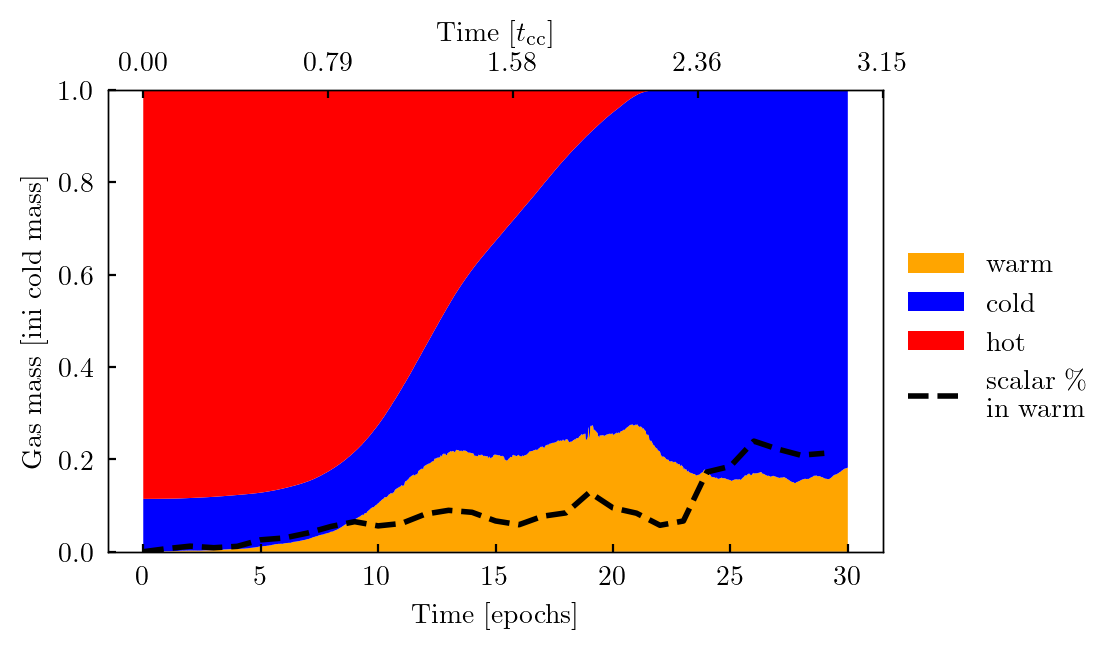

In [50]:
trial = '240711_0.8_1600000'
cg_st_epoch = 0
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
# try
try:
    fname = f'{datapath}/turb/Turb.hst'
    with open(fname, 'r') as file: keys_raw = file.readlines()[1]
    keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
except:
    fname = f'{datapath}/cloud/Turb.hst'
    with open(fname, 'r') as file: keys_raw = file.readlines()[1]
    keys = [a.split('=')[1] for a in keys_raw.split()[1:]]

fname = f'{datapath}/cloud/Turb.hst'
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}

# mass fractions
cold_frac_all = dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch]  # cold gas fraction
warm_frac_all = dataf['warm_gas'] / dataf['cold_gas'][cg_st_epoch]  # warm gas fraction

"""Crop the mass at the stop time"""
stop_time = dataf['time'][-1]  # the last time in hst
stop_ind = len(cold_frac_all)  # the last hst
cold_frac_cropped = cold_frac_all[:stop_ind]
warm_frac_cropped = warm_frac_all[:stop_ind]
stop_time_cc = stop_time / rp['t_cc']

fig, ax1 = plt.subplots(figsize=(5,3))

# plot hst version
cg_st_epoch = 0
# ax1.plot(dataf['time'] / rp['dt_hdf5'], cold_frac_all, ls='--', color='blue', alpha=0.3)
# ax1.plot(dataf['time'] / rp['dt_hdf5'], warm_frac_all, ls='--', color='orange', alpha=0.3)
# # plot the cropped version in solid
# ax1.plot(dataf['time'][:stop_ind] / rp['dt_hdf5'], cold_frac_cropped, ls='-', color='blue', label='Cold gas mass', alpha=1)
# ax1.plot(dataf['time'][:stop_ind] / rp['dt_hdf5'], warm_frac_cropped, ls='-', color='orange', label='Warm gas mass', alpha=1)

# hot gas mass from total mass
tot_mass = np.sum(get_datamd(fname=f'{datapath}/cloud/Turb.out2.00001.athdf', key='rho', verbose=False)) * ((rp['box_size'] / rp['grid_dim']) ** 3)
cg_mass = dataf['cold_gas']
wg_mass = dataf['warm_gas']

print(tot_mass, cg_mass, wg_mass)
hot_mass = tot_mass - cg_mass - wg_mass
hot_mass_cropped = tot_mass - cg_mass[:stop_ind] - wg_mass[:stop_ind]

# plot a stack plot
ax1.stackplot(dataf['time'][:stop_ind] / rp['dt_hdf5'],
              wg_mass[:stop_ind]/tot_mass,
              cg_mass[:stop_ind]/tot_mass,
              hot_mass_cropped/tot_mass,
              labels=['warm', 'cold', 'hot'],
              colors=['orange', 'blue', 'red'])
# plot the scalar percentage in the warm gas
ax1.plot(time_athdf/rp['dt_hdf5'], np.array(scalar_warm)/ini_scalar_sum, ls='--', color='k', label='scalar \%\n in warm')

ax1.set_ylim(0, 1)
ax1.set_ylabel('Gas mass [ini cold mass]')
ax1.set_xlabel('Time [epochs]')

# alternative t_cc axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
t_cc_ticks = np.linspace(0, ax1.get_xlim()[1], 5)
t_cc_labels = (t_cc_ticks * rp['dt_hdf5']) / rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels(f'{x:.2f}' for x in t_cc_labels)
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")
ax1.legend(bbox_to_anchor=(1, 0.7),
           alignment='center')#, frameon=True,
           #fancybox=False, shadow=True)
plt.show()

## Scalar bin temperature dist

Looks at the temperature distribution for cells with scalar value < and > a cutoff threshold

- this is useful to track where the original cold gas had gone

In [12]:
# temperature evolution for cells with scalar > 50

trial = '240711_0.4_1600'  # trial when everything converts to the warm gas
cold_cloud_ratio = 2  # T_cold / T_cloud

from tqdm import tqdm
datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

"""read parameters"""
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

"""construct a list of files"""
file_list = np.sort([f'{datapath}/cloud/{f}' for f in os.listdir(f'{datapath}/cloud') if f.startswith('Turb.out2') and f.endswith('.athdf')])

# arrays to append to
time_athdf = []  # time array for the athdfs
temp_athdf = []  # temperature array for the athdfs
scalar_athdf = []

for fname in tqdm(file_list):
    t, press, rho, r = get_datamds(fname=fname, keys=['Time', 'press', 'rho', 'r0'], verbose=False)
    scalar = np.array(r) * np.array(rho)  # scalar is scaled by density
    temperature = calc_T(press, rho)  # calculate temperature from the two
    
    # cells with less and more scalar
    time_athdf.append(t)
    temp_athdf.append(temperature)
    scalar_athdf.append(scalar)

100%|████████████████████████████████████████████████████████████████████████████████████████| 32/32 [05:08<00:00,  9.65s/it]


In [13]:
scalar_thres = 0.1

temp_large = []  # temperature for cells with large scalar values
temp_small = []  # temperature for cells with small scalar values

for temperature, scalar in tqdm(zip(temp_athdf, scalar_athdf)):
    temp_large.append(np.array(temperature[scalar > scalar_thres]).flatten())
    temp_small.append(np.array(temperature[scalar <= scalar_thres]).flatten())

32it [00:06,  4.92it/s]


### Line regions

In [ ]:
# temp_arr = []
# for temp in temp_large:
#     temp_arr.append(np.array([0]) if len(temp) == 0 else temp)

# # x axis
# X = time_athdf/rp['dt_hdf5']

# # y axis, calculate distributions
# Y = [np.median(temp) for temp in temp_arr]
# Y_1sigma_l = [np.percentile(temp, 15.9) for temp in temp_arr]
# Y_1sigma_h = [np.percentile(temp, 84.1) for temp in temp_arr]
# Y_2sigma_l = [np.percentile(temp, 2.3) for temp in temp_arr]
# Y_2sigma_h = [np.percentile(temp, 97.7) for temp in temp_arr]

In [ ]:
# do binned statistics
from scipy.stats import binned_statistic as bs
temp_arr = []
for temp in temp_large:
    temp_arr.append(np.array([0]) if len(temp) == 0 else temp)

# number of bins
nbins = 10

X_raw = time_athdf/rp['dt_hdf5']
Y_raw = [np.median(temp) for temp in temp_arr]
X_bins = np.linspace(X_raw.min(), X_raw.max(), nbins)
X = (X_bins[:-1] + X_bins[1:]) / 2

# functions
Y, _, _ = bs(X_raw, Y_raw, np.mean, bins=X_bins)
Y_1sigma_l, _, _ = bs(X_raw, Y_raw, lambda x: np.percentile(x, 15.9), bins=X_bins)
Y_1sigma_h, _, _ = bs(X_raw, Y_raw, lambda x: np.percentile(x, 84.1), bins=X_bins)
Y_2sigma_l, _, _ = bs(X_raw, Y_raw, lambda x: np.percentile(x, 2.3), bins=X_bins)
Y_2sigma_h, _, _ = bs(X_raw, Y_raw, lambda x: np.percentile(x, 97.7), bins=X_bins)

In [ ]:
from matplotlib.ticker import FixedLocator
from scipy.stats import binned_statistic as bs

fig, ax1 = plt.subplots(figsize=(5,3))
# plot scalar evolution
ax1.plot(X, Y, ls='-', lw=1, color='blue', alpha=1, label='High')
ax1.fill_between(X, Y_1sigma_l, Y_1sigma_h, ls='-', color='blue', alpha=0.3)
ax1.fill_between(X, Y_2sigma_l, Y_2sigma_h, ls='-', color='blue', alpha=0.2)
# ax1.plot(X, Y, ls='-', color='red', alpha=1, label='Low')
ax1.set_yscale('log')

ax1.set_ylabel('Temperature distribution [T]')
ax1.set_xlabel('Time [epochs]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Set major ticks
t_cc_labels = np.linspace(0, ax2.get_xlim()[1] * rp['dt_hdf5'] / rp['t_cc'] // 10 * 10 * 2, 5)
t_cc_ticks = t_cc_labels / rp['dt_hdf5'] * rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels([f'{x:.0f}' for x in t_cc_labels])
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

# Add minor ticks without labels between 0 and 5
minor_locator = FixedLocator(np.arange(0, 5, 1) / rp['dt_hdf5'] * rp['t_cc'])  # Adjust the interval as needed
ax2.xaxis.set_minor_locator(minor_locator)

ax1.legend()
plt.show()

### 2d histogram plot

In [14]:
# # temperature bins
# nbins_temp = 20
# bins_temp = np.power(10., np.linspace(8e2, 1e6, nbins_temp))

# # 2d histogram in time, temperature
# temp_hist2d = []
# for temp in temp_large:
#     hist = temp
#     temp_hist2d.append(hist)

# plt.hist2d

In [17]:
# temperature bins
nbins_temp = 200
bins_temp = np.power(10., np.linspace(np.log10(8e2), np.log10(1e6), nbins_temp))

# time bins
bins_time = time_athdf/rp['dt_hdf5']
temps = [temp_large, temp_small]  # large and small
xyvals = []

imgdata = [[], []]
for i, temp_switch in enumerate(temps):  # for both larger and smaller
    for temp in temp_switch:  # for each epoch
        hist, _ = np.histogram(temp, bins=bins_temp)
        imgdata[i].append(hist)

/tmp/ipykernel_1136/2750630853.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


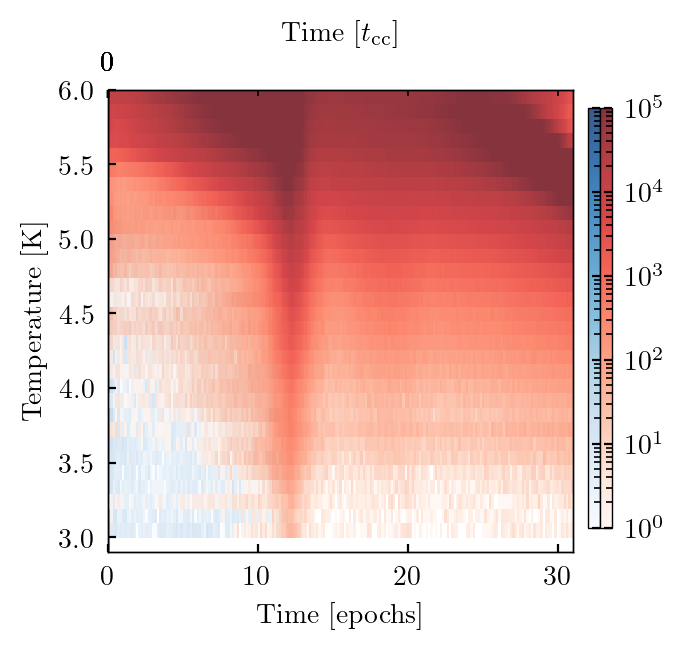

In [25]:
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LogNorm

fig, ax1 = plt.subplots(figsize=(3, 3))

cmaps = ['Blues', 'Reds']
imgs = []
for cmap, xyval in zip(cmaps, imgdata):
    img = \
    ax1.imshow(xyval,
               cmap=cmap, alpha=0.8,
               norm=LogNorm(vmin=1, vmax=1e5),
               aspect="auto",
               extent=[bins_time.min(),bins_time.max(),
                       np.log10(8e2), np.log10(1e6)])
    imgs.append(img)

# colorbars
cbar_ax1 = fig.add_axes([0.925, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = plt.colorbar(imgs[0], cax=cbar_ax1)
cbar1.set_ticklabels([])
cbar_ax2 = fig.add_axes([0.945, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar2 = plt.colorbar(imgs[1], cax=cbar_ax2)

# axis settings
# ax1.set_yscale('log')

ax1.set_ylabel('Temperature [K]')
ax1.set_xlabel('Time [epochs]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Set major ticks
t_cc_labels = np.linspace(0, ax2.get_xlim()[1] * rp['dt_hdf5'] / rp['t_cc'] // 10 * 10, 5)
t_cc_ticks = t_cc_labels / rp['dt_hdf5'] * rp['t_cc']
ax2.set_xticks(t_cc_ticks)
ax2.set_xticklabels([f'{x:.0f}' for x in t_cc_labels])
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

# Add minor ticks without labels between 0 and 5
minor_locator = FixedLocator(np.arange(0, 5, 1) / rp['dt_hdf5'] * rp['t_cc'])  # Adjust the interval as needed
ax2.xaxis.set_minor_locator(minor_locator)

ax1.legend()
plt.show()

In [ ]:
all_time = []
for time, temp in zip(bins_time, temp_large):  # only looking at cloud
    all_time.append([time] * len(temp))

time_len = [len(time) for time in all_time]
plt.plot(bins_time, time_len)
plt.yscale('log')
plt.show()